In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import lib.fun_plotting as fun_plotting
from lib.ml_wrapper import asynch_reconstruction

from sklearn.decomposition import PCA

In [2]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

/mnt/DAA0C4FEA0C4E1DD/Users/gnico/OneDrive - Università degli Studi di Padova/PhD/projects/neurons/rec_and_knock_high_dimensional/lib/fun_asynch.py:170: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  return 1/delta_t*(np.dot(spins[:,1:], spins[:,:-1].T)/Nsteps - cov)


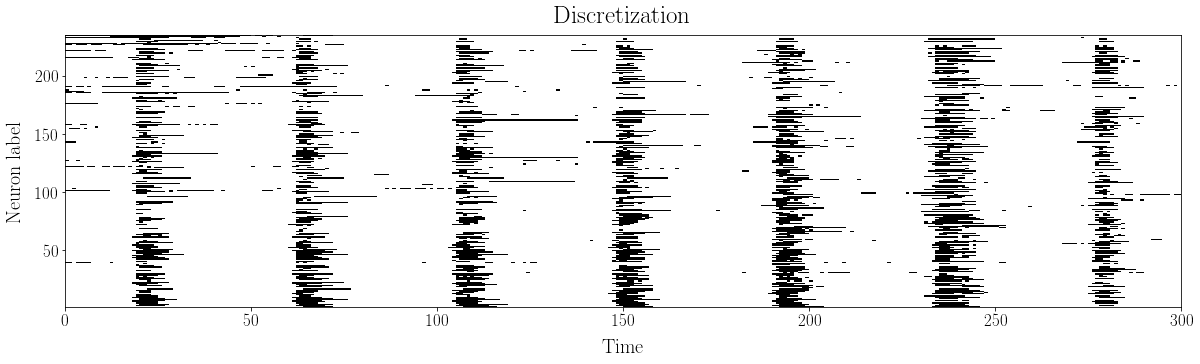

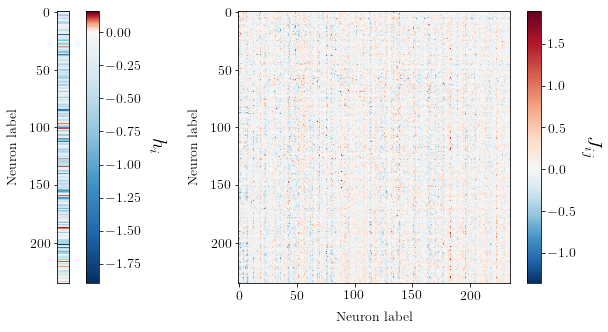

/mnt/DAA0C4FEA0C4E1DD/Users/gnico/OneDrive - Università degli Studi di Padova/PhD/projects/neurons/rec_and_knock_high_dimensional/lib/fun_asynch.py:134: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  slist[:,idx+1] = asynch_glauber_dynamics(h, J, slist[:,idx], delta_t, gamma)


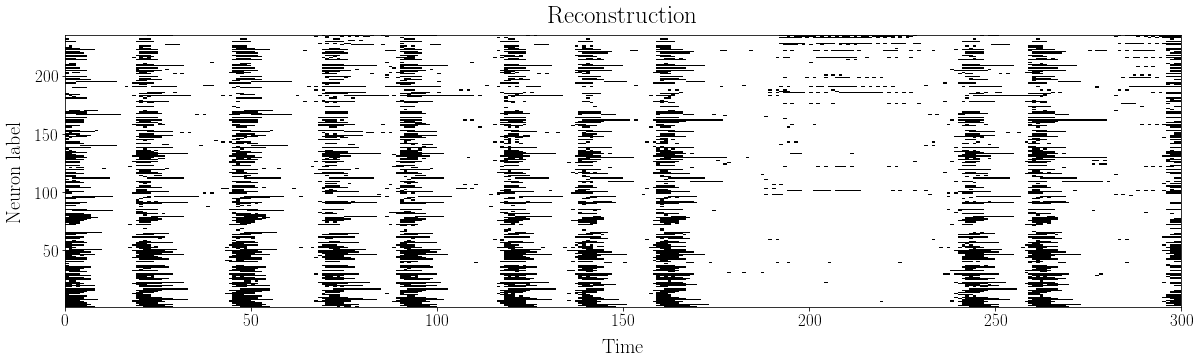

In [3]:
Nepochs = 800
LAMBDA = 0.05
lr = 0.5
drop = 0.8
edrop = 20

s = str(Nepochs)+'_'+str(LAMBDA)+'_'+str(lr)+'_'+str(drop)+'_'+str(edrop)+'.npy'

data_discrete = np.load('experimental_data/data_discrete.npy')
model = asynch_reconstruction(data_discrete, delta_t = 1, LAMBDA = LAMBDA, opt = 'NADAM', reg = 'L1')

model.load_parameters(J = np.load('model_parameters/J' + s), h = np.load('model_parameters/h' + s))

fun_plotting.raster_plot(data_discrete, 'Discretization', delta_t = 1)
plt.show()

model.plot_fields_and_couplings()
plt.show()

fun_plotting.raster_plot(model.generate_samples(), 'Reconstruction', delta_t = 1)
plt.show()

In [5]:
log_emission_matrix = np.load('model_parameters/task_all_best_log_emission_matrix.npy')
log_transition_matrix = np.load('model_parameters/task_all_best_log_transition_matrix.npy')

emission_matrix = np.exp(log_emission_matrix)
transition_matrix = np.exp(log_transition_matrix)

N_neurons = log_emission_matrix.shape[1]
N_hidden = log_emission_matrix.shape[0]

emission_list = np.zeros((N_neurons, N_hidden, N_neurons))
transition_list = np.zeros((N_neurons, N_hidden, N_hidden))

for idx in range(N_neurons):
    emission_list[idx] = np.exp(np.load('model_parameters/task_k'+str(idx)+'_best_log_emission_matrix.npy'))
    transition_list[idx] = np.exp(np.load('model_parameters/task_k'+str(idx)+'_best_log_transition_matrix.npy'))

In [6]:
N_neurons, N_hidden

(235, 2)

In [7]:
full_matrix = np.zeros((N_neurons+1, N_hidden*(N_hidden+N_neurons)))
for idx in range(N_neurons):
    full_matrix[idx] = np.concatenate([transition_list[idx].ravel(),
                                       emission_list[idx].ravel()])
full_matrix[-1] = np.concatenate([transition_matrix.ravel(), emission_matrix.ravel()])

In [8]:
pca = PCA(n_components=2)
X = pca.fit_transform(full_matrix)

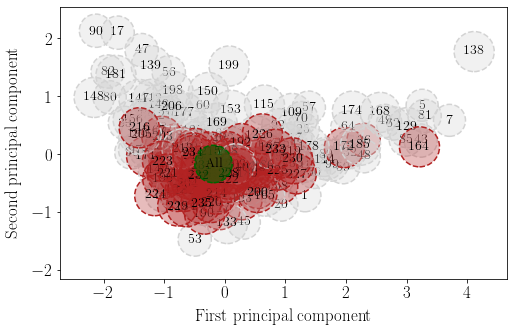

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

idx_list = np.where([emission_matrix[1] > emission_matrix[1].mean()])[1]
plt.scatter(X[:, 0], X[:,1], s = 0)

for idx in range(N_neurons):
    if idx in idx_list:
        color = 'firebrick'
    else:
        color = 'lightgray'
    plt.text(X[idx,0], X[idx,1], str(idx + 1), ha="center", va="center", fontsize = 14,
             bbox = dict(boxstyle = f"Circle, pad={0.7}",
                         fc = matplotlib.colors.colorConverter.to_rgba(color, alpha=.3),
                         ls = '--', lw = 1.5,
                         edgecolor = color))
plt.text(X[-1,0], X[-1,1], 'All', ha="center", va="center", fontsize = 14,
         bbox = dict(boxstyle = f"Circle, pad={0.7}",
                     fc = matplotlib.colors.colorConverter.to_rgba('darkgreen', alpha=.6),
                     ls = '--', lw = 1.5,
                     edgecolor = 'darkgreen'))

ax.set_xlabel('First principal component', fontsize = 17, labelpad = 10)
ax.set_ylabel('Second principal component', fontsize = 17, labelpad = 10)
ax.tick_params(labelsize=17)
ax.set_ylim(ax.get_ylim()[0]*1.3, ax.get_ylim()[1]*1.1)
ax.set_xlim(ax.get_xlim()[0]*1.1, ax.get_xlim()[1]*1.05)
plt.show()

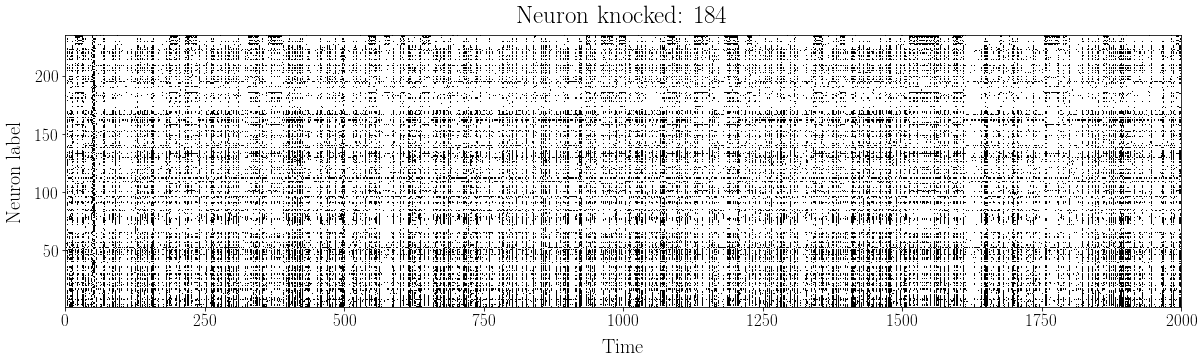

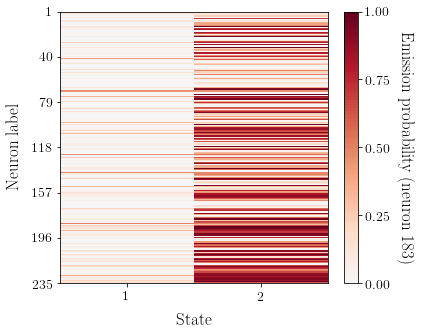

In [10]:
cosine_similarity = emission_list.prod(axis = 1).sum(axis = 1)
cosine_similarity /= np.sqrt((emission_list**2).sum(axis = 2)).prod(axis = 1)

idx_cos = np.where(cosine_similarity > np.mean(cosine_similarity) + 3*np.std(cosine_similarity))[0]

for idx in idx_cos:
    _, _, s = model.knockout_neurons([idx], plot = False)
    fig, ax = fun_plotting.raster_plot(s, title = 'Neuron knocked: ' + str(idx+1), delta_t = 1/30)
    plt.show()
    
    fig, ax = fun_plotting.plot_probability_mat(emission_list[idx].T,
                                                'Emission probability (neuron '+str(idx)+')',
                                                Ymax = 1, Ymin = N_neurons, Xmax = N_hidden)
    ax.set_xlabel('State', fontsize = 17, labelpad = 10)
    ax.set_ylabel('Neuron label', fontsize = 17, labelpad = 10)
    ax.set_yticks(np.linspace(1, N_neurons, 7).astype('int'))
    plt.show()

In [11]:
def DKL_tmat(tmat_knock, tmat_model):
    l = np.ma.log(tmat_knock/tmat_model)
    div = tmat_knock*l.filled(0)
    return np.sum(div, axis = 1)

In [12]:
temporal_disruption = np.zeros((N_neurons, 2))
for idx, tmat in enumerate(transition_list):
    temporal_disruption[idx] = DKL_tmat(transition_list[idx], transition_matrix)

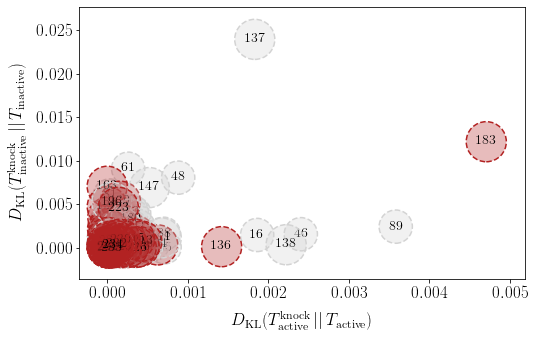

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

idx_list = np.where([emission_matrix[1] > emission_matrix[1].mean()])[1]
plt.scatter(temporal_disruption[:,1], temporal_disruption[:,0], s = 0)

for idx in range(N_neurons):
    if idx in idx_list:
        color = 'firebrick'
    else:
        color = 'lightgray'
    ax.text(temporal_disruption[idx,1], temporal_disruption[idx,0], str(idx), ha="center", va="center", fontsize = 14,
             bbox = dict(boxstyle = f"Circle, pad={0.7}",
                         fc = matplotlib.colors.colorConverter.to_rgba(color, alpha=.3),
                         ls = '--', lw = 1.5,
                         edgecolor = color))

ax.set_xlabel(r'$D_\mathrm{KL}(T_\mathrm{active}^\mathrm{knock} \, || \, T_\mathrm{active})$', fontsize = 17, labelpad = 10)
ax.set_ylabel(r'$D_\mathrm{KL}(T_\mathrm{inactive}^\mathrm{knock} \, || \, T_\mathrm{inactive})$', fontsize = 17, labelpad = 10)
ax.tick_params(labelsize=17)
ax.set_ylim(ax.get_ylim()[0]*3, ax.get_ylim()[1]*1.1)
ax.set_xlim(ax.get_xlim()[0]*1.5, ax.get_xlim()[1]*1.05)
plt.show()

In [14]:
emission_disruption = np.zeros((N_neurons,2))
for idx, emat in enumerate(emission_list):
    for i in range(2):
        emission_disruption[idx, i] = (emat[i]*emission_matrix[i]).sum()
        emission_disruption[idx, i] /= np.sqrt(np.sum(emission_matrix[i]**2)*np.sum(emat[i]**2))
emission_disruption = 1 - emission_disruption

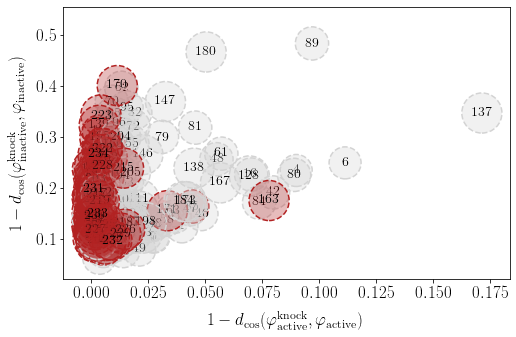

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

idx_list = np.where([emission_matrix[1] > emission_matrix[1].mean()])[1]
plt.scatter(emission_disruption[:,1], emission_disruption[:,0], s = 0)

for idx in range(N_neurons):
    if idx in idx_list:
        color = 'firebrick'
    else:
        color = 'lightgray'
    ax.text(emission_disruption[idx,1], emission_disruption[idx,0], str(idx), ha="center", va="center", fontsize = 14,
            bbox = dict(boxstyle = f"Circle, pad={0.7}",
                         fc = matplotlib.colors.colorConverter.to_rgba(color, alpha=.3),
                         ls = '--', lw = 1.5,
                         edgecolor = color))

ax.set_xlabel(r'$1 - d_\mathrm{cos}(\varphi_\mathrm{active}^\mathrm{knock}, \varphi_\mathrm{active})$',
              fontsize = 17, labelpad = 10)
ax.set_ylabel(r'$1 - d_\mathrm{cos}(\varphi_\mathrm{inactive}^\mathrm{knock}, \varphi_\mathrm{inactive})$',
              fontsize = 17, labelpad = 10)
ax.tick_params(labelsize=17)
ax.set_ylim(ax.get_ylim()[0]*(0.5), ax.get_ylim()[1]*1.1)
ax.set_xlim(ax.get_xlim()[0]*(1.5), ax.get_xlim()[1]*1.02)
plt.show()

In [16]:
x, y = temporal_disruption.mean(axis = 1), emission_disruption.mean(axis = 1)

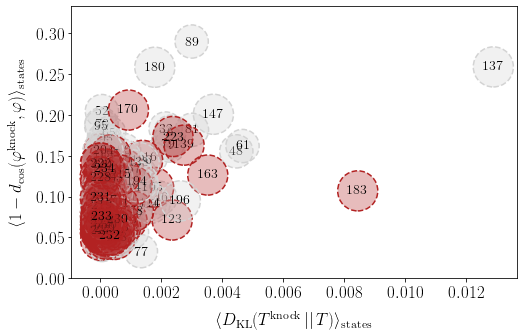

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

idx_list = np.where([emission_matrix[1] > emission_matrix[1].mean()])[1]
plt.scatter(x, y, s = 0)

for idx in range(N_neurons):
    if idx in idx_list:
        color = 'firebrick'
    else:
        color = 'lightgray'
    ax.text(x[idx], y[idx], str(idx), ha="center", va="center", fontsize = 14,
            bbox = dict(boxstyle = f"Circle, pad={0.7}",
                         fc = matplotlib.colors.colorConverter.to_rgba(color, alpha=.3),
                         ls = '--', lw = 1.5,
                         edgecolor = color))

ax.set_xlabel(r'$\langle D_\mathrm{KL}(T^\mathrm{knock} \, || \, T)\rangle_\mathrm{states}$',
              fontsize = 17, labelpad = 10)
ax.set_ylabel(r'$\langle 1 - d_\mathrm{cos}(\varphi^\mathrm{knock}, \varphi) \rangle_\mathrm{states}$',
              fontsize = 17, labelpad = 10)
ax.tick_params(labelsize=17)
ax.set_ylim(0, ax.get_ylim()[1]*1.1)
ax.set_xlim(ax.get_xlim()[0]*1.5, ax.get_xlim()[1]*1.01)

plt.show()

In [21]:
def get_ranked_array(x):
    result = np.empty(len(x), dtype=int)
    temp = x.argsort()
    result[temp] = np.arange(len(x))
    return result

def rank_product(obs):
    Nobs = obs.shape[0]
    for idx in range(Nobs):
        obs[idx] = get_ranked_array(obs[idx])
    return obs.prod(axis = 0)**1/Nobs

In [22]:
get_ranked_array(x)

array([ 68, 157, 181, 178, 221, 102, 222, 187,  62, 170,  13,  22,  55,
       164, 130, 104, 215,  91,   1, 149, 122,  59, 186, 138, 193, 160,
        45, 195,  27, 134, 118,  71, 219,  29,  69,  38, 183,  52,  33,
       147, 209, 119,  70, 171, 203, 158, 218,  87, 231, 114,  39,   7,
        58, 188, 126, 166,  12, 176,  46, 213,  90, 232, 143,  19,   4,
       150, 129,  50, 153, 172,  49,   5,  96, 151,  53,  41,   0, 211,
        35, 220, 197, 228,  75, 116,  44,  60,  57,  23, 206, 227,  97,
        89, 194, 155, 198,  40, 121,   2,  86,  79, 191,  54,  24, 113,
       174, 216, 189,  76,  66, 199,  28, 200, 139,  17, 214, 110,  81,
       146, 162,  73,   9, 148, 156, 223, 161, 120, 212,  64, 192,  63,
       140,  99, 125, 141, 109,  80, 196, 234, 210, 226,  32, 208,  84,
        78,  11,  37, 103, 230, 123, 136,  72,  95, 127, 179, 101, 106,
        61,  85,  20, 154,  93,  26, 124, 229,  88, 117,  98, 202, 100,
         6, 201, 112,  47,  56, 105,  15, 142,  25, 205,  31, 21

In [23]:
rprod = np.argsort(rank_product(np.vstack([x,y])))[::-1]

In [24]:
rprod + 1

array([138,  90, 148,  82, 181,  62, 224,   7,  33, 140,  49,  80,   5,
       171,  17, 164, 127, 139,  81,  41, 129, 168, 137, 184, 106, 195,
       216, 182, 142,  44, 196,  66,  47,  54, 197,  10, 206, 112, 107,
        74, 115,  60, 123, 185,  69,  97,  25, 203,  40, 202, 190, 113,
       133, 179,  89,  46, 156, 235,  95,  63,  23, 160,  70,  73, 147,
        93, 167, 218,  42,  15, 204, 125, 134, 155,  84, 166, 124,   2,
       118, 152, 205, 199,  56,  24, 231, 110, 172,   3, 187, 163,  18,
       150, 189, 149,  43,  48, 191, 158,  53, 161, 108, 151,   8,   6,
       177,  26, 104, 128,  71,  21, 213,  31, 117, 101,  68,  99, 174,
        32,  96, 214, 227, 126, 157, 198,  92,  85,  75, 221,  20, 119,
        61, 215, 153,  38,   4, 169, 217, 201, 219, 109, 130,  27,  45,
        36, 220, 132,  91, 193, 192,  94,  59, 212, 165, 100, 230, 162,
       136, 144, 188,  76,   1,  58,  88, 154,  28, 207,  16, 102,  35,
        12,  55,  67,  22, 122, 223, 211,  34, 234,  64, 233,  8

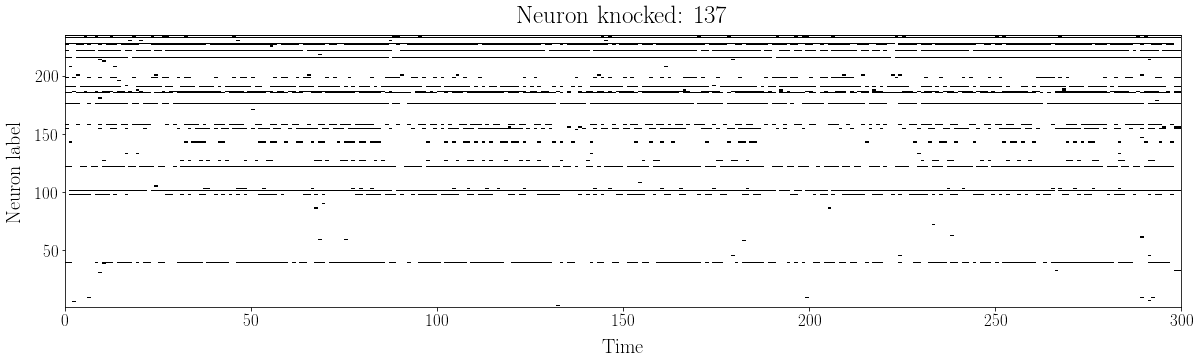

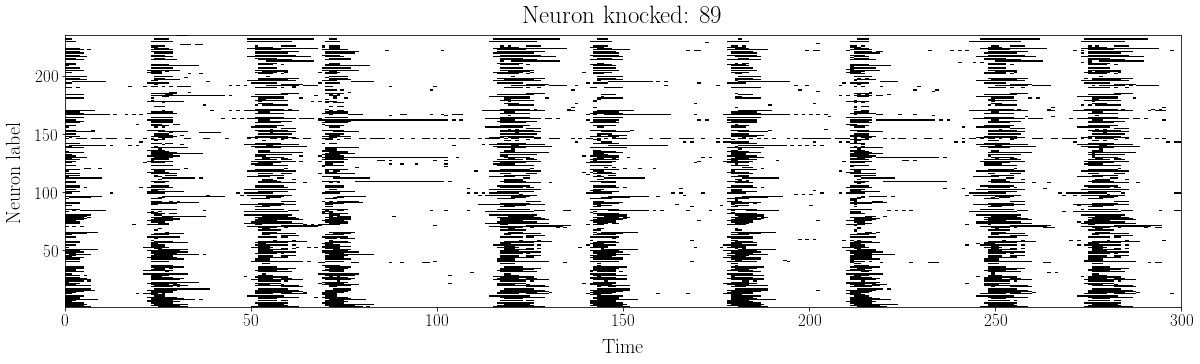

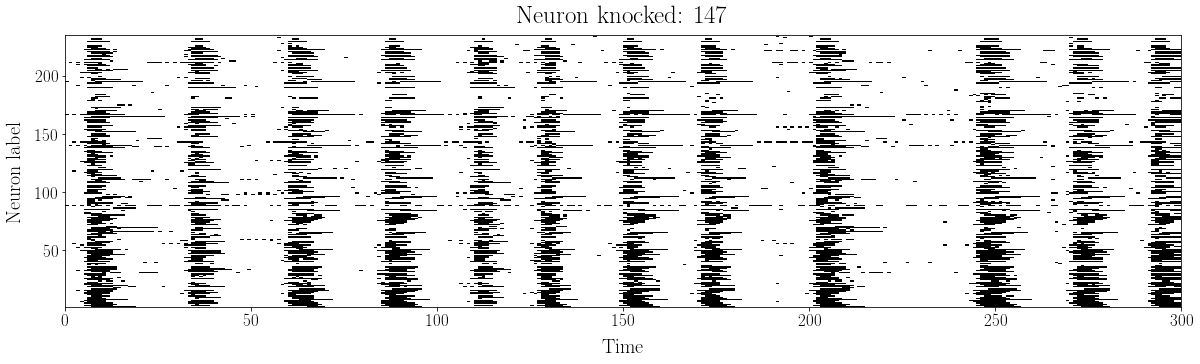

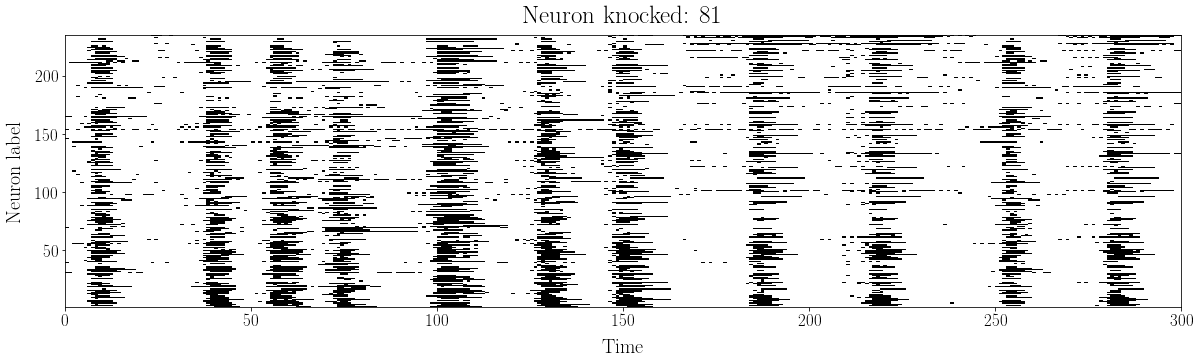

In [28]:
for r, idx in enumerate(rprod[:4]):
    _, _, s = model.knockout_neurons([idx], Nsteps = 300, plot = False)
    fig, ax = fun_plotting.raster_plot(s, title = 'Neuron knocked: ' + str(idx), delta_t = 1)
    plt.show()

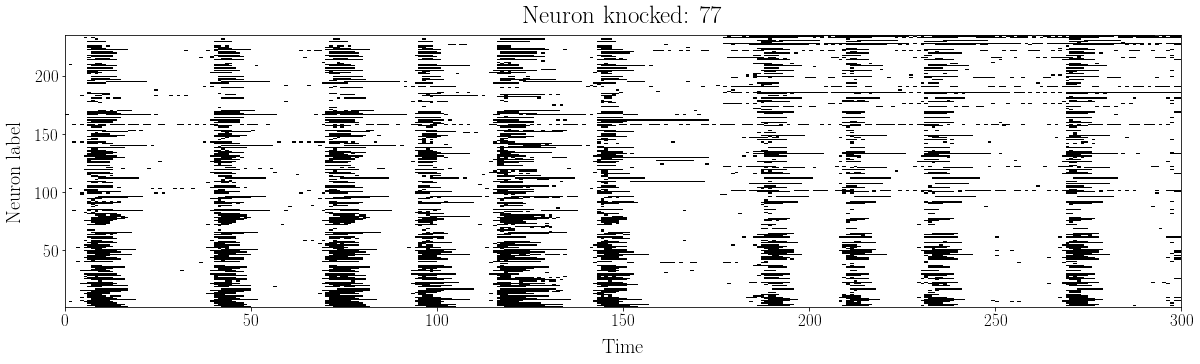

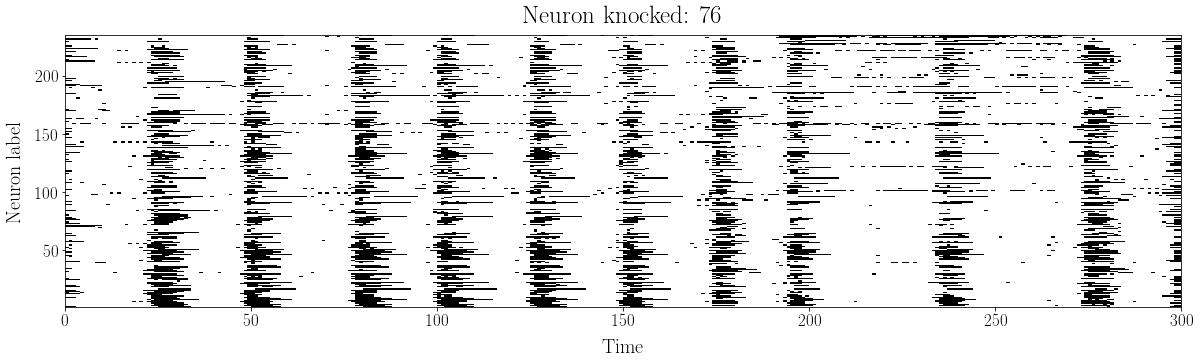

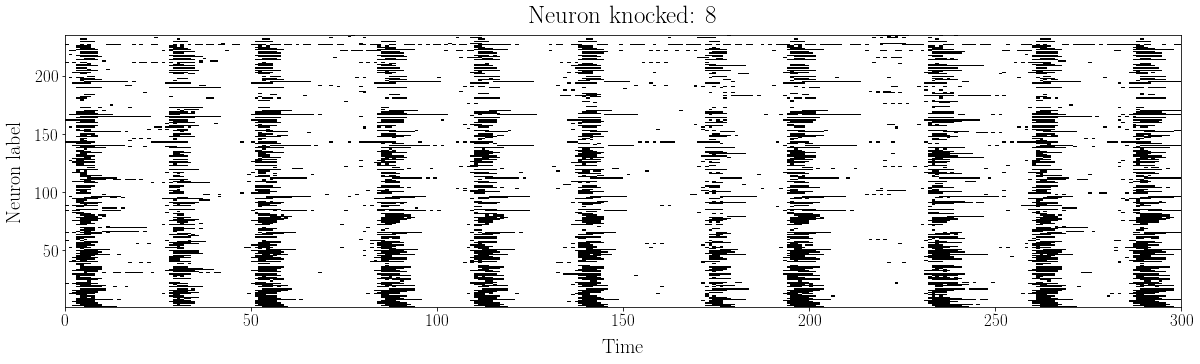

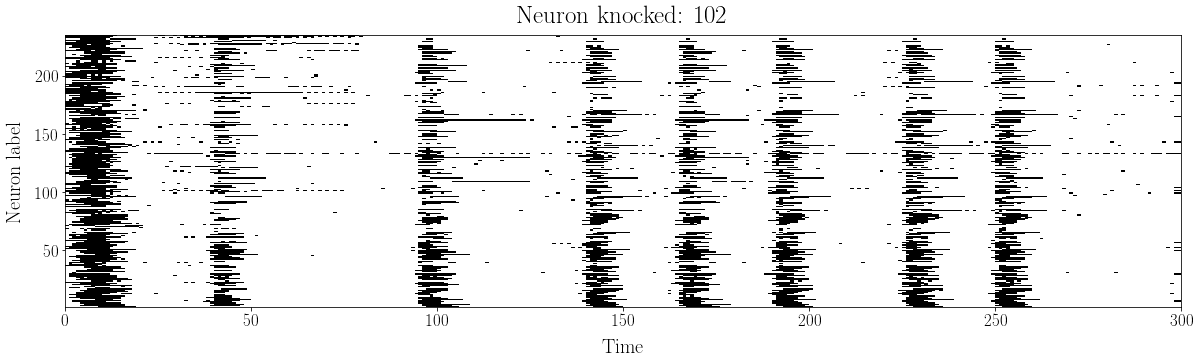

In [29]:
for r, idx in enumerate(rprod[::-1][:4]):
    _, _, s = model.knockout_neurons([idx], plot = False, Nsteps = 300)
    fig, ax = fun_plotting.raster_plot(s, title = 'Neuron knocked: ' + str(idx), delta_t = 1)

    plt.show()

In [ ]:
for idx in range(N_neurons):

In [181]:
enhanced_matrix = np.zeros((N_neurons+1, 4))
for idx in range(N_neurons):
    enhanced_matrix[idx, 0:2] = temporal_disruption[idx]
    enhanced_matrix[idx, 2:4] = emission_disruption[idx]

In [182]:
pca = PCA(n_components=2)
X = pca.fit_transform(enhanced_matrix)

In [189]:
x0 = pca.transform(np.array([[0,0,0,0]]))

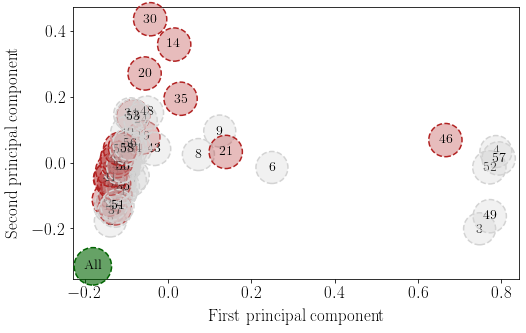

In [190]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

idx_list = np.where([emission_matrix[1] > emission_matrix[1].mean()])[1]

ax.scatter(X[:,0], X[:,1], s = 0)

for idx in range(N_neurons):
    if idx in idx_list:
        color = 'firebrick'
    else:
        color = 'lightgray'
    ax.text(X[idx,0], X[idx,1], str(idx), ha="center", va="center", fontsize = 14,
            bbox = dict(boxstyle = f"Circle, pad={0.7}",
                        fc = matplotlib.colors.colorConverter.to_rgba(color, alpha=.3),
                        ls = '--', lw = 1.5,
                        edgecolor = color))
    
plt.text(x0[-1,0], x0[-1,1], 'All', ha="center", va="center", fontsize = 14,
         bbox = dict(boxstyle = f"Circle, pad={0.7}",
                     fc = matplotlib.colors.colorConverter.to_rgba('darkgreen', alpha=.6),
                     ls = '--', lw = 1.5,
                     edgecolor = 'darkgreen'))


ax.set_xlabel('First principal component', fontsize = 17, labelpad = 10)
ax.set_ylabel('Second principal component', fontsize = 17, labelpad = 10)
ax.tick_params(labelsize=17)
plt.show()

In [191]:
test = np.zeros(N_neurons)
for idx in range(N_neurons):
    test[idx] = np.sqrt(np.sum((X[idx] - x0)**2))

In [192]:
np.argsort(test)[::-1]

array([ 4, 57, 52, 49,  3, 46, 30, 14, 20, 35,  6,  9, 48, 21, 34, 17, 53,
       24,  8, 40, 19, 43, 56, 54, 23, 58, 47, 55, 45,  7, 18, 44, 39, 50,
       26, 42, 27, 38,  0,  5, 10, 25, 41, 32, 33, 36, 13, 12, 28, 31, 22,
       16,  1, 29, 51, 11, 15, 37,  2])

<Figure size 720x360 with 0 Axes>

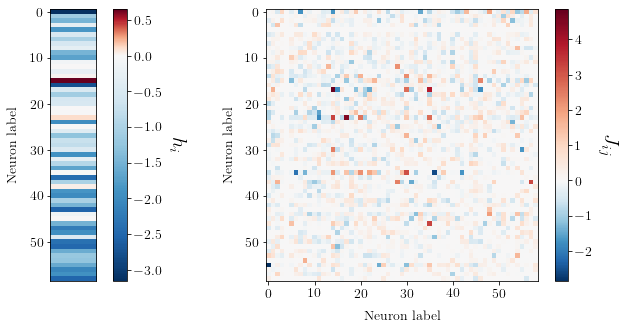

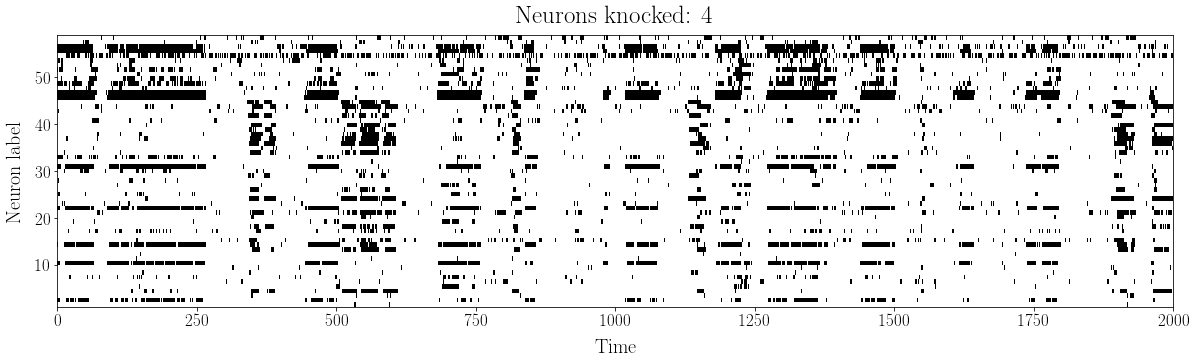

<Figure size 720x360 with 0 Axes>

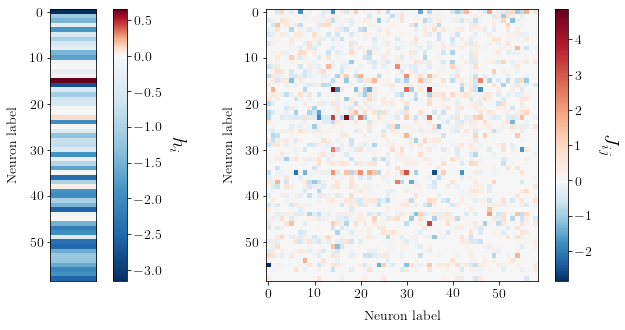

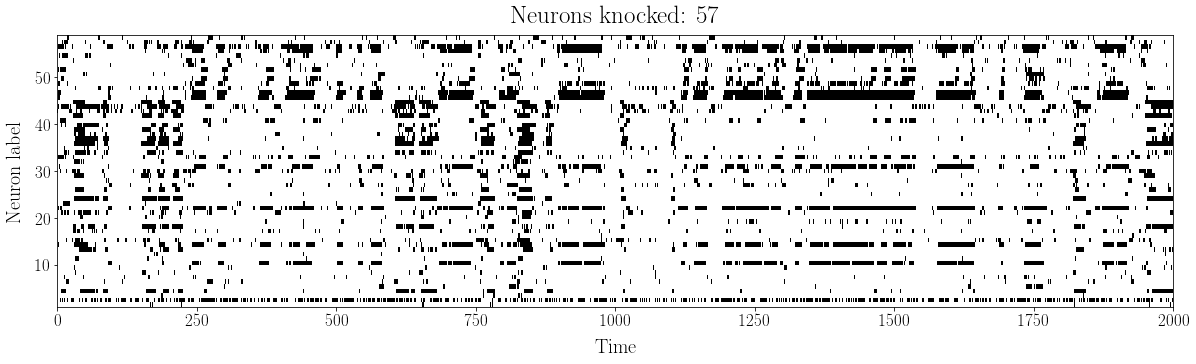

<Figure size 720x360 with 0 Axes>

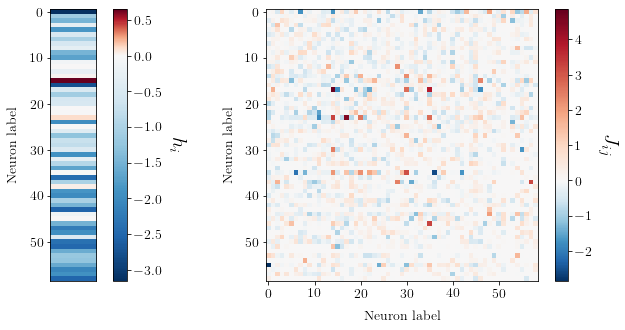

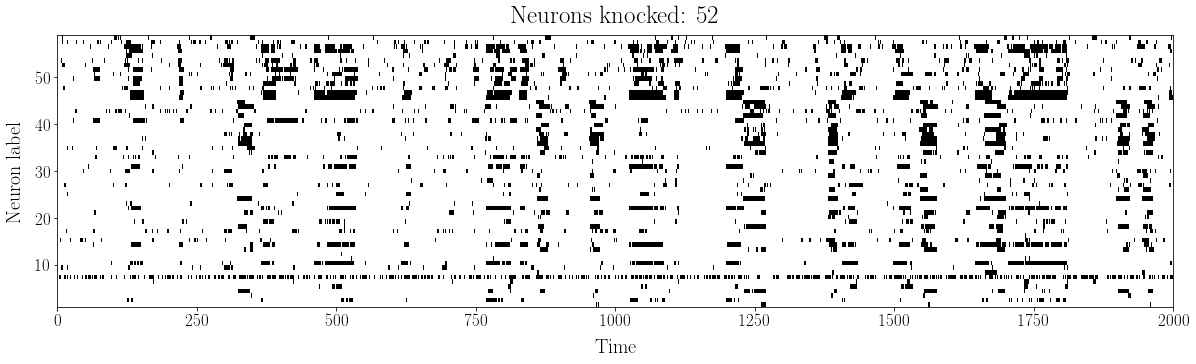

<Figure size 720x360 with 0 Axes>

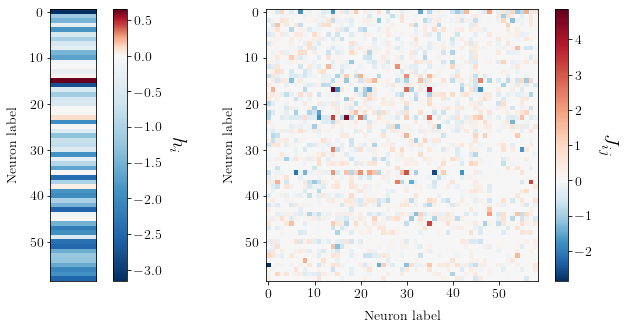

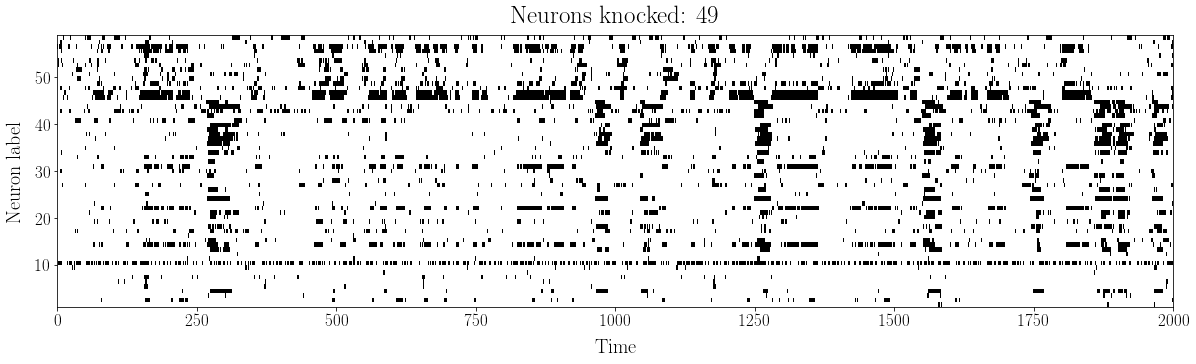

<Figure size 720x360 with 0 Axes>

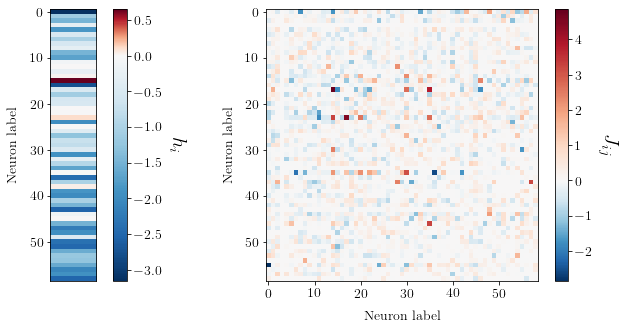

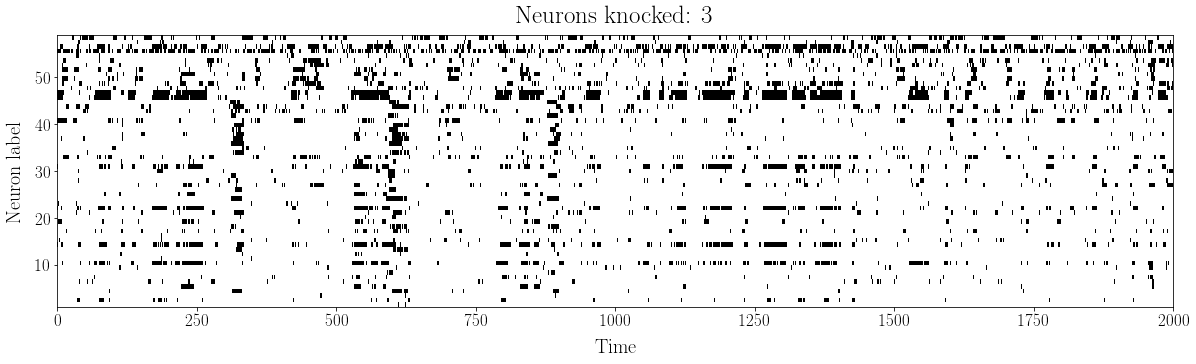

<Figure size 720x360 with 0 Axes>

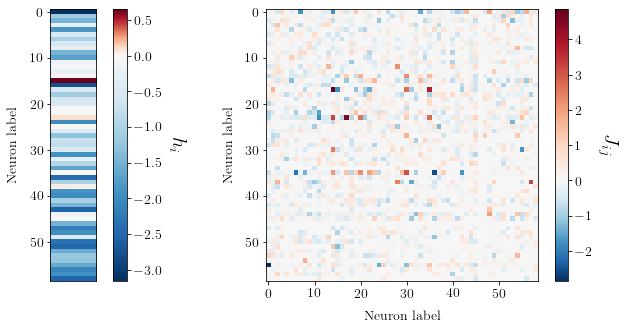

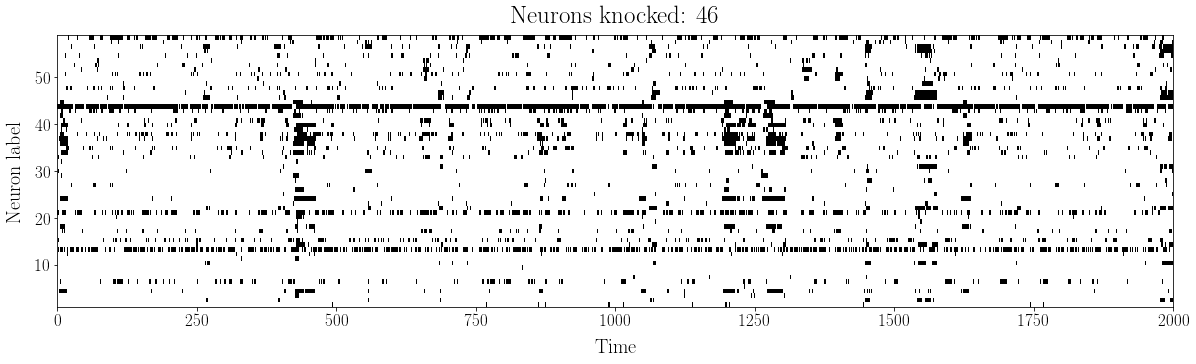

<Figure size 720x360 with 0 Axes>

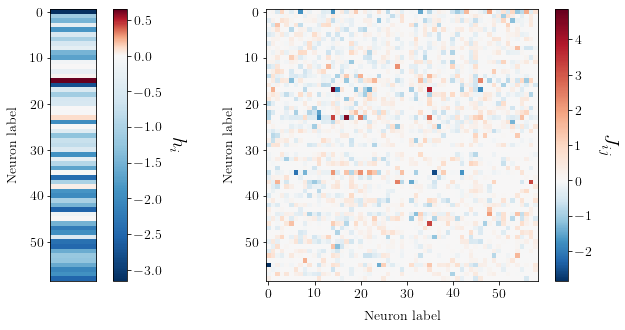

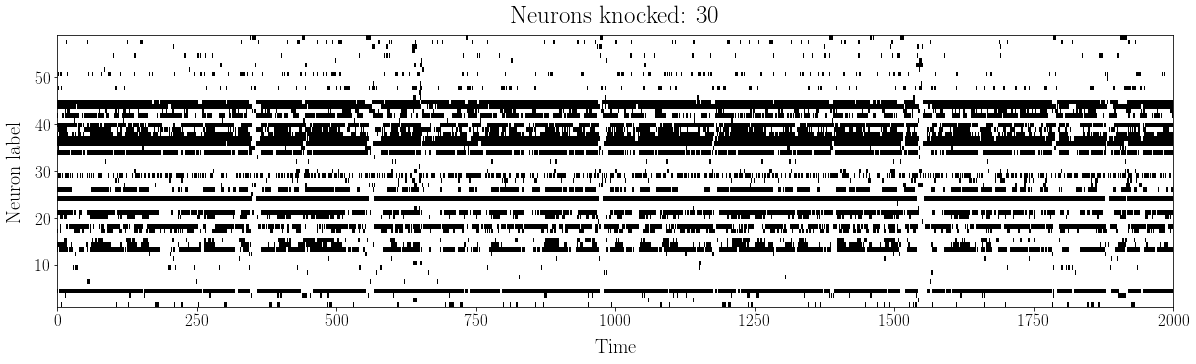

<Figure size 720x360 with 0 Axes>

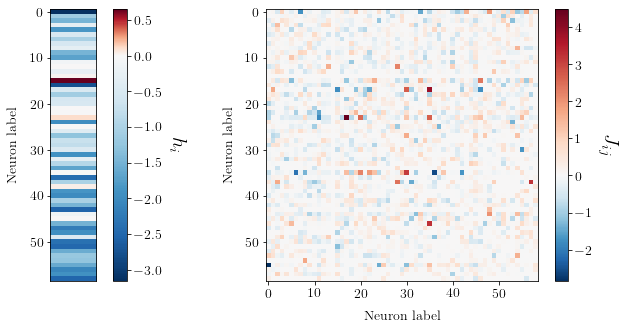

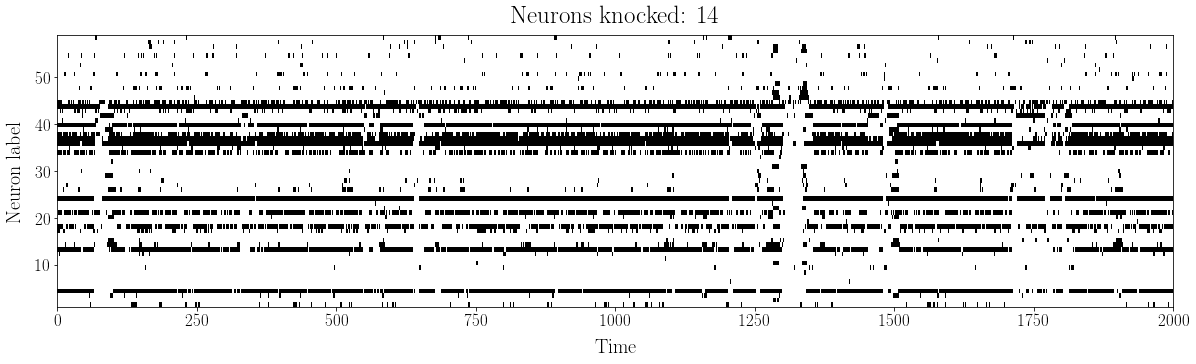

<Figure size 720x360 with 0 Axes>

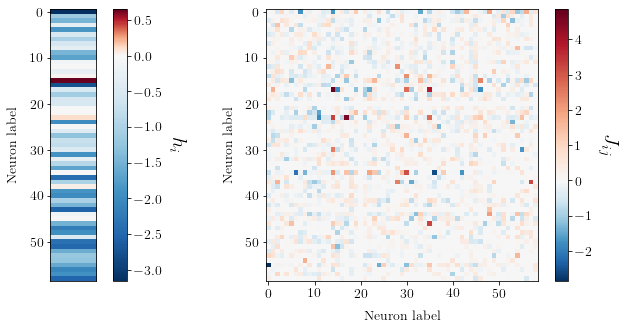

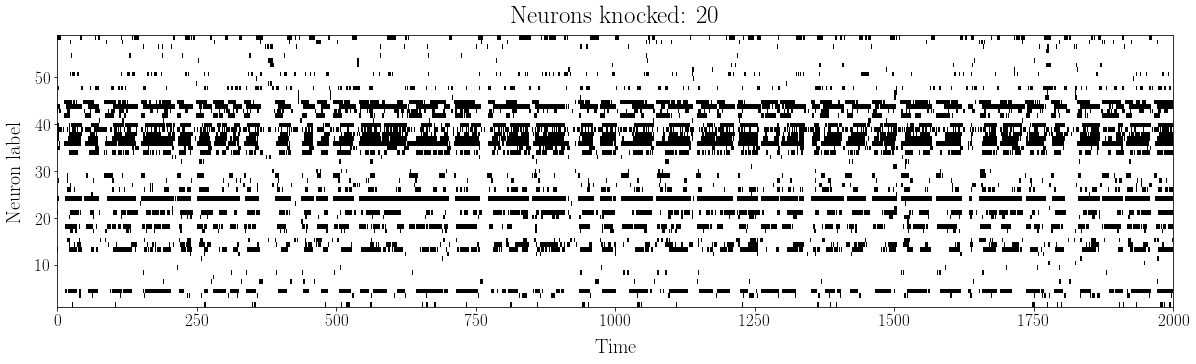

<Figure size 720x360 with 0 Axes>

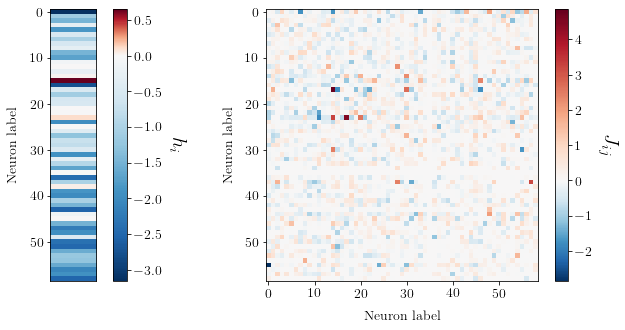

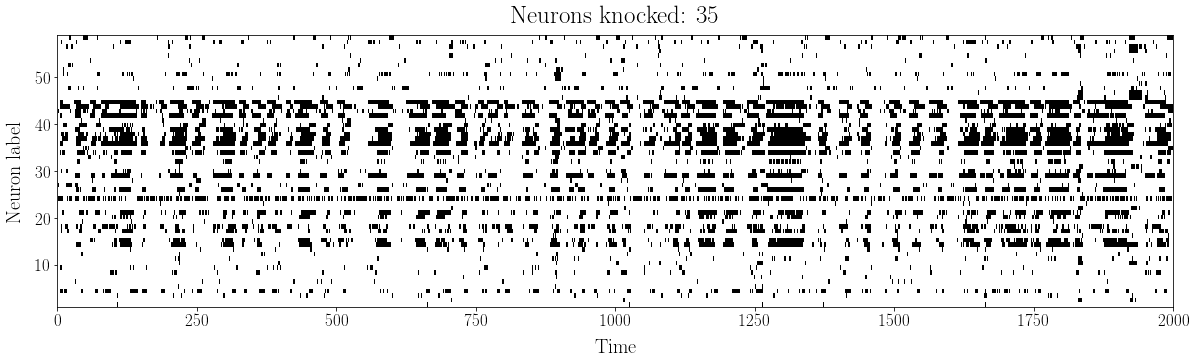

<Figure size 720x360 with 0 Axes>

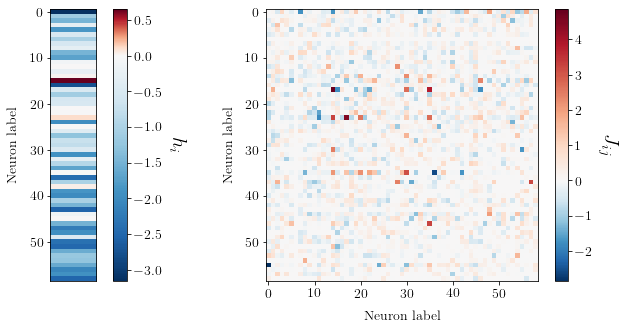

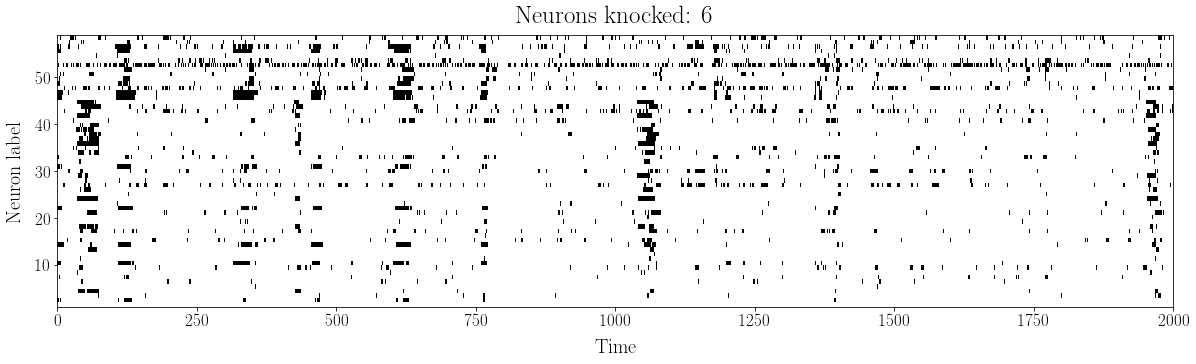

<Figure size 720x360 with 0 Axes>

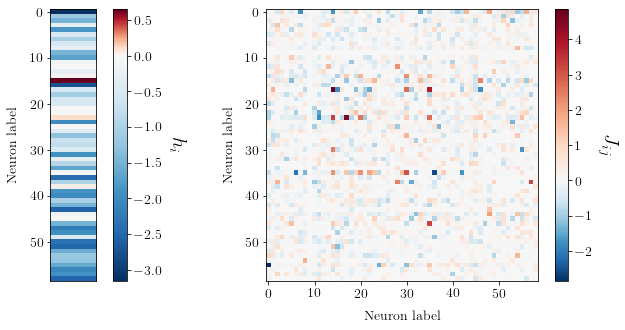

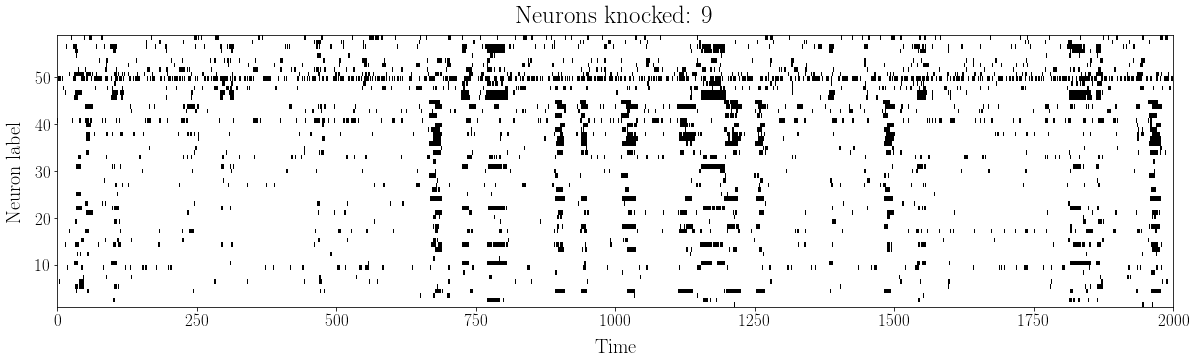

<Figure size 720x360 with 0 Axes>

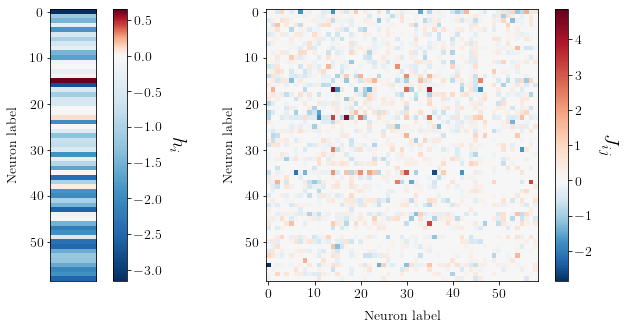

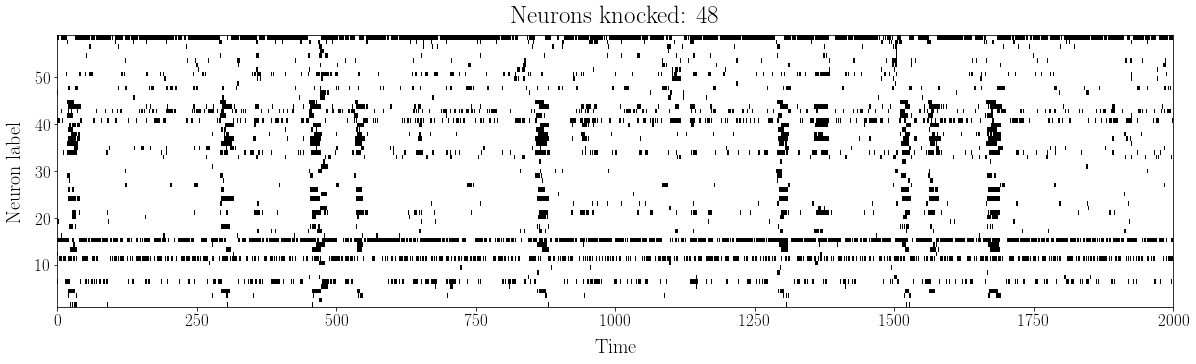

<Figure size 720x360 with 0 Axes>

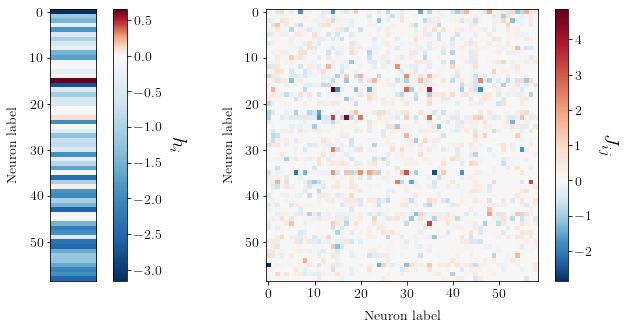

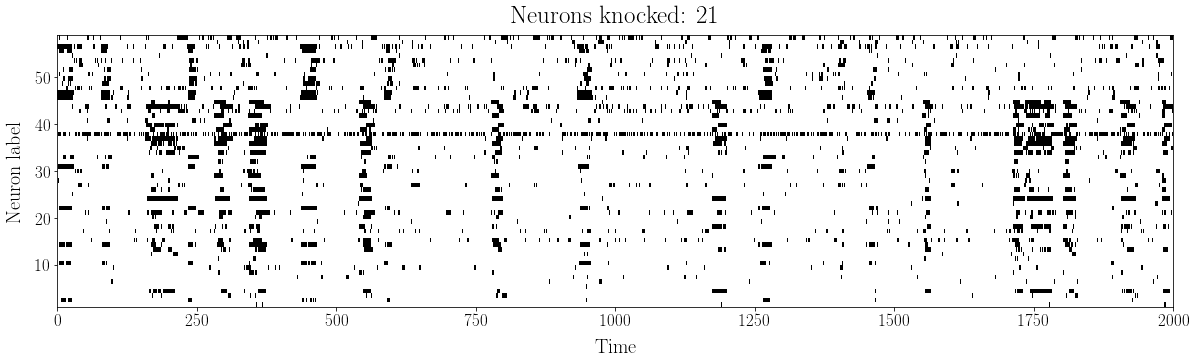

<Figure size 720x360 with 0 Axes>

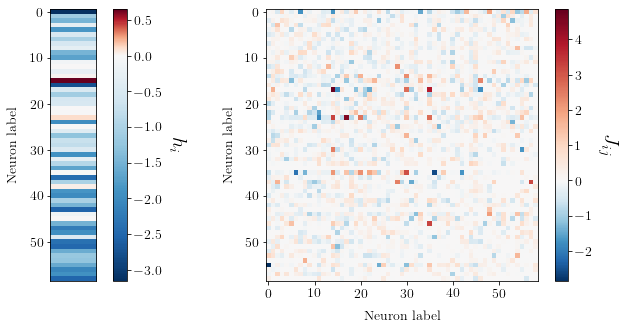

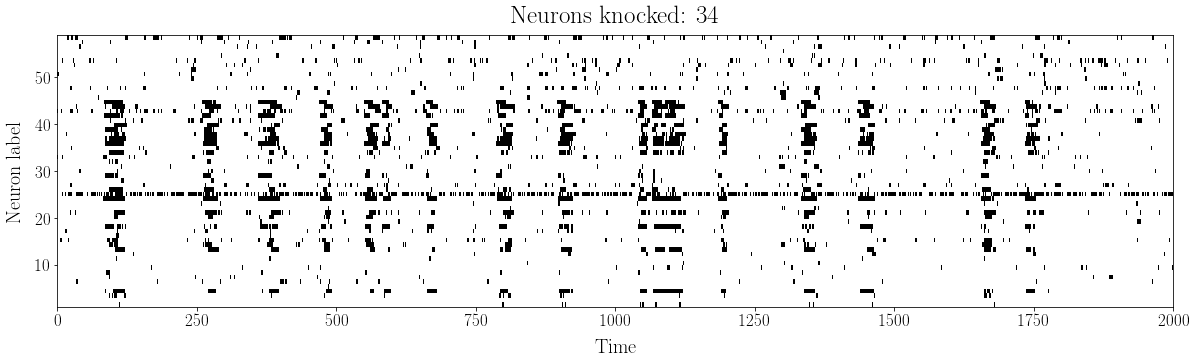

<Figure size 720x360 with 0 Axes>

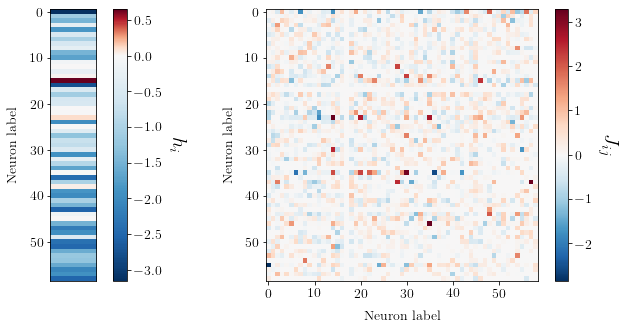

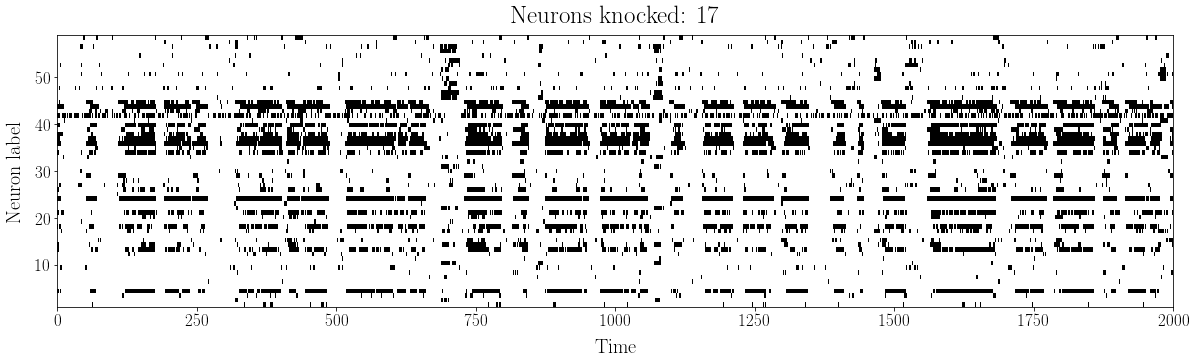

<Figure size 720x360 with 0 Axes>

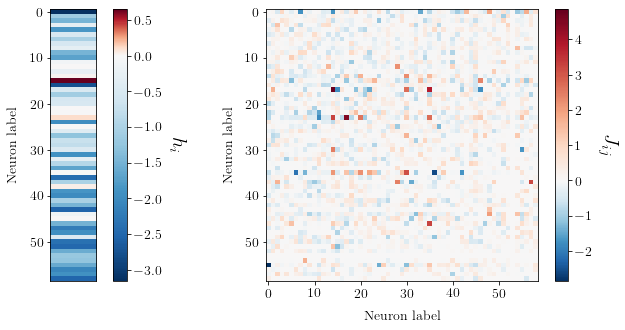

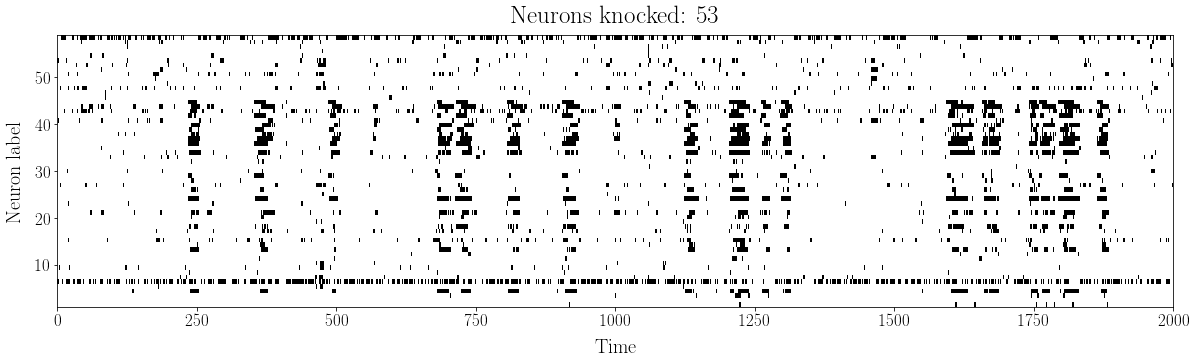

<Figure size 720x360 with 0 Axes>

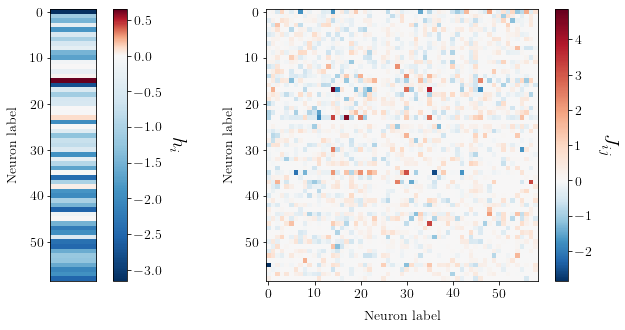

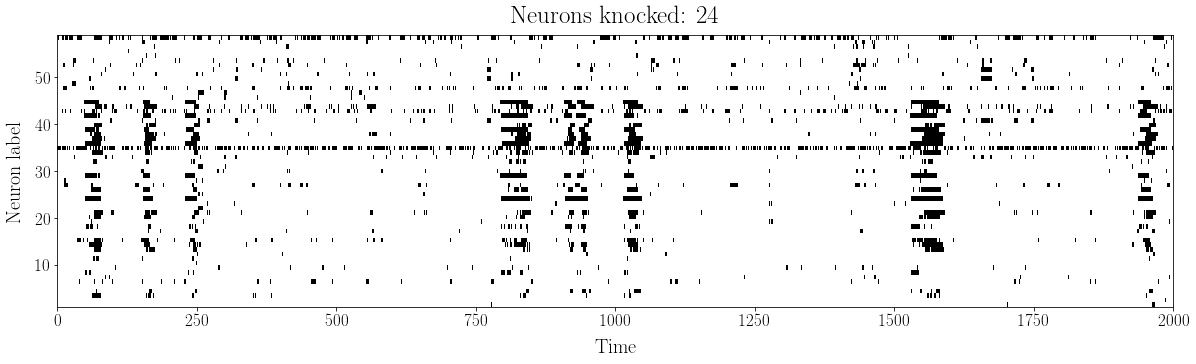

<Figure size 720x360 with 0 Axes>

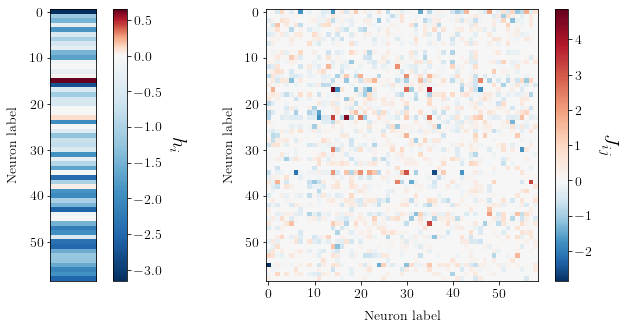

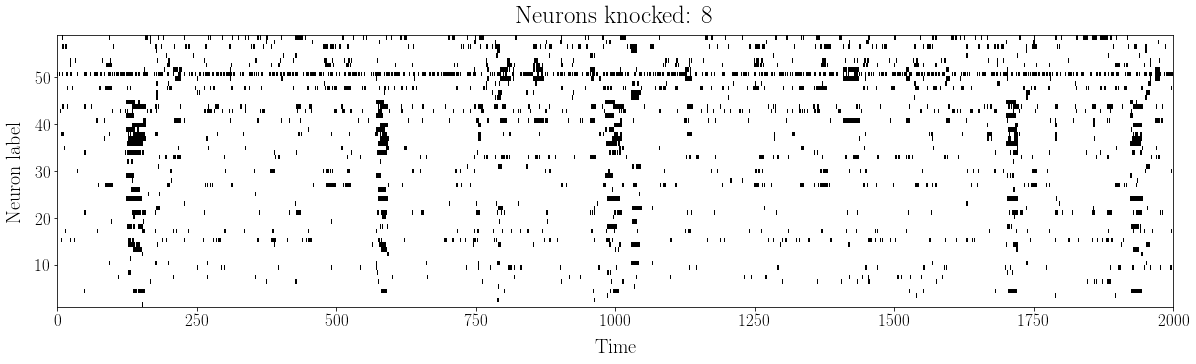

<Figure size 720x360 with 0 Axes>

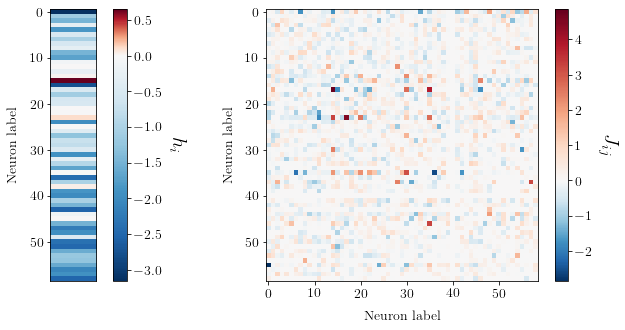

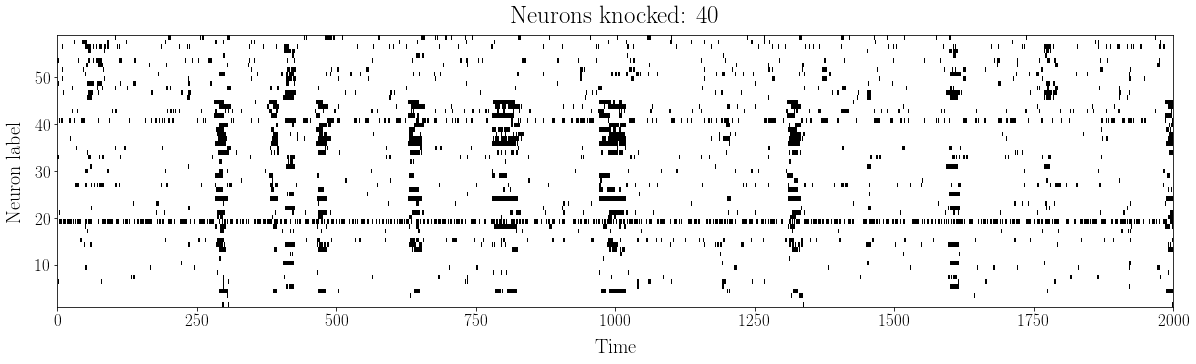

<Figure size 720x360 with 0 Axes>

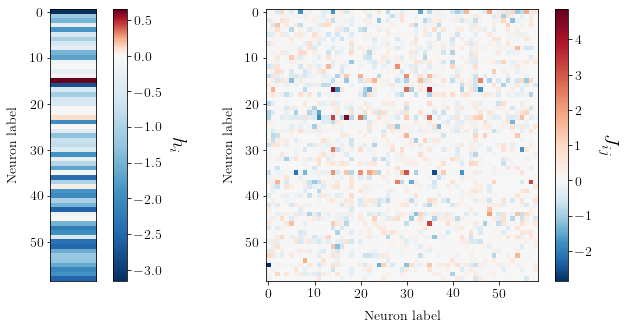

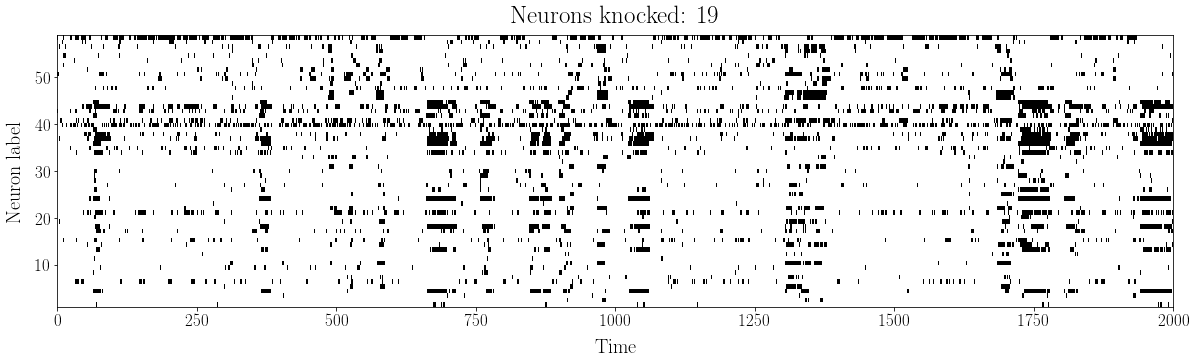

<Figure size 720x360 with 0 Axes>

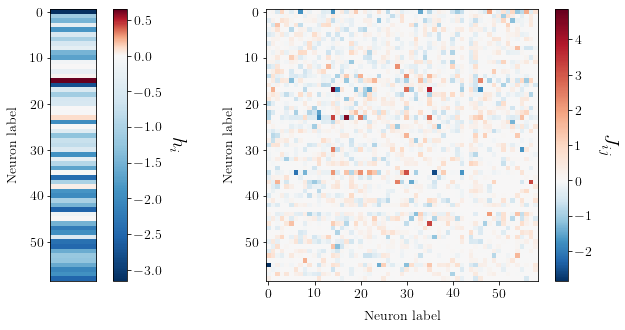

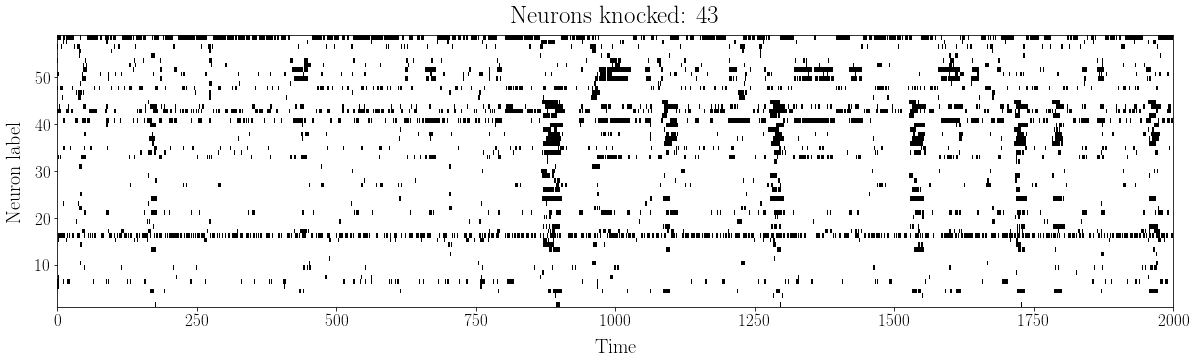

<Figure size 720x360 with 0 Axes>

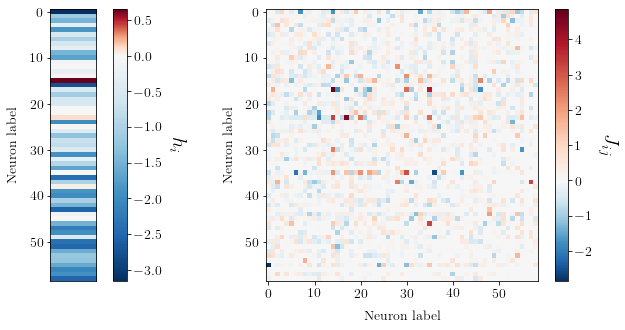

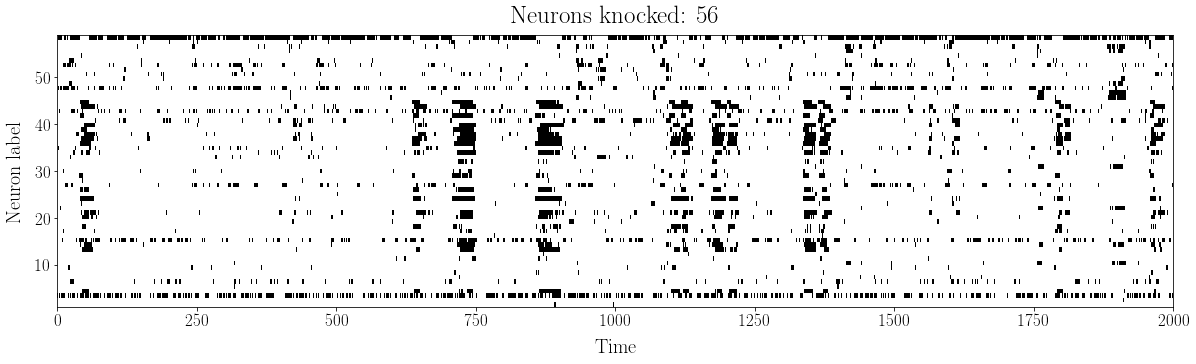

<Figure size 720x360 with 0 Axes>

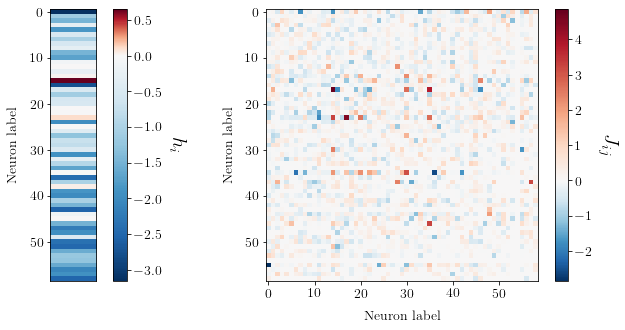

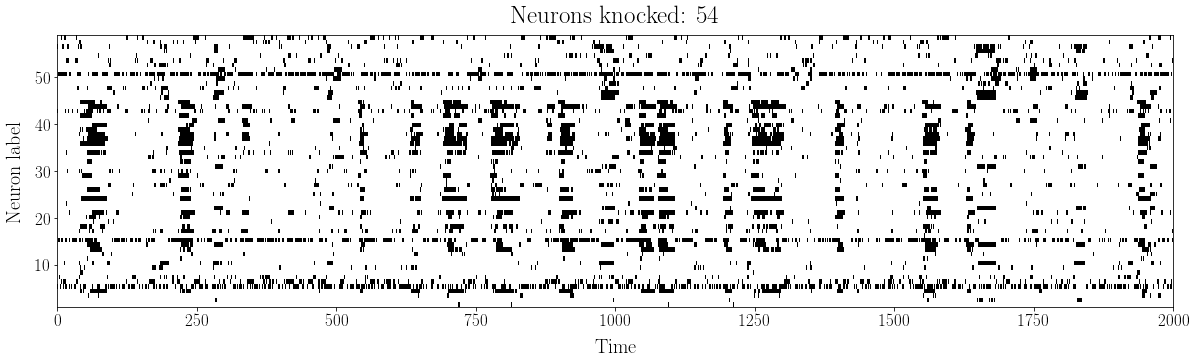

<Figure size 720x360 with 0 Axes>

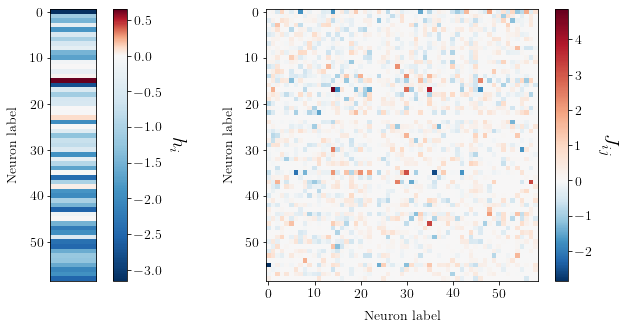

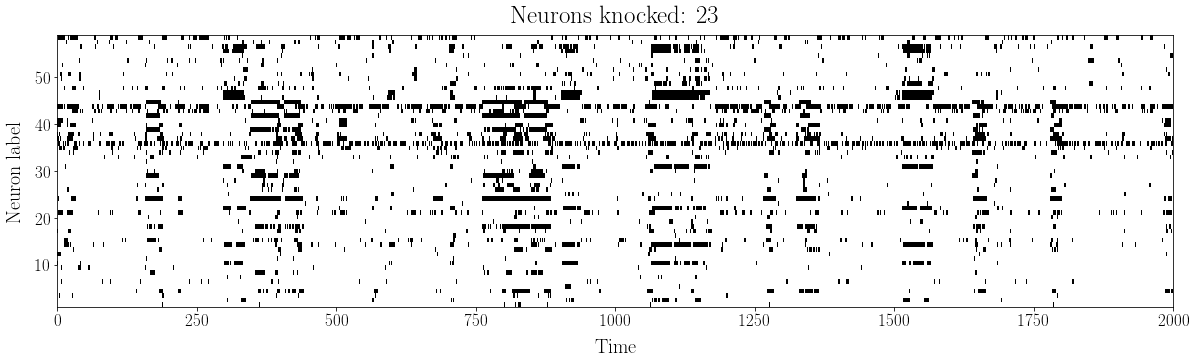

<Figure size 720x360 with 0 Axes>

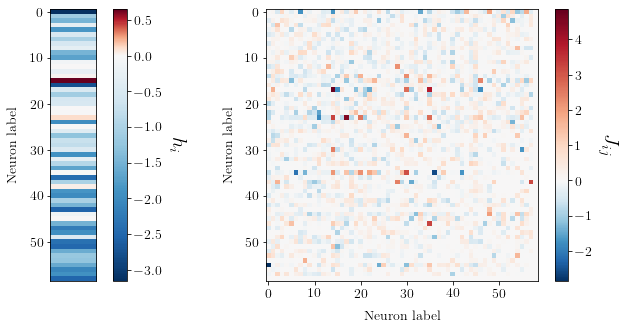

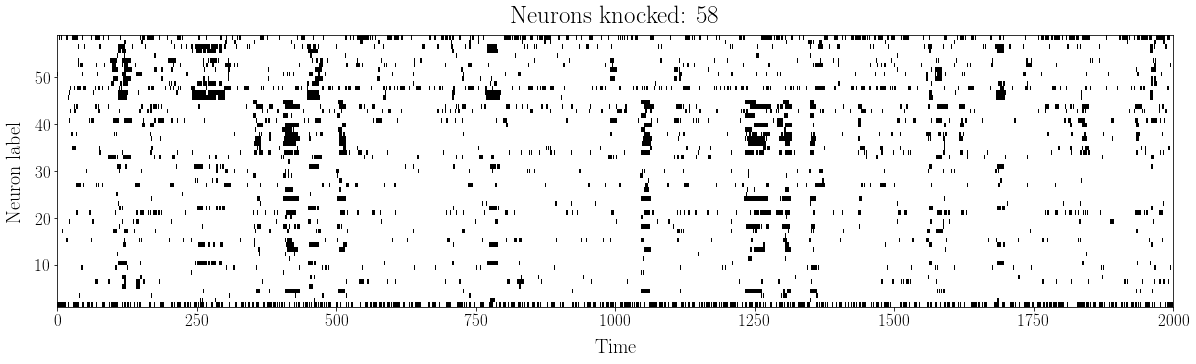

<Figure size 720x360 with 0 Axes>

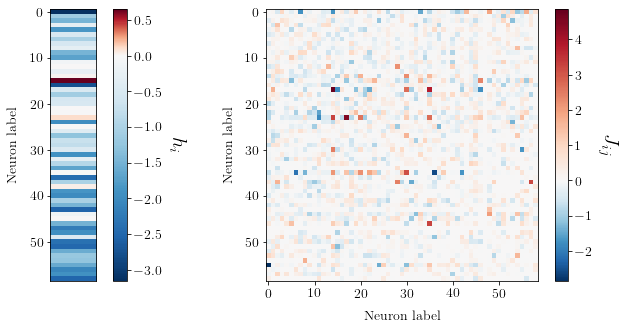

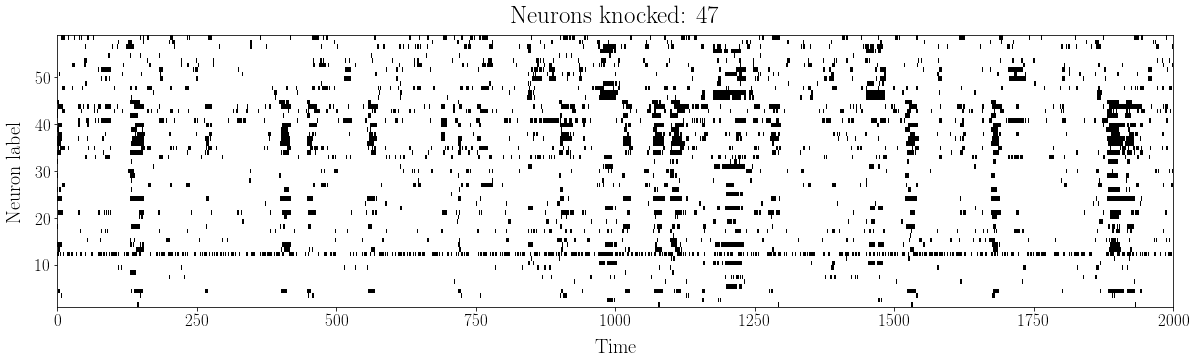

<Figure size 720x360 with 0 Axes>

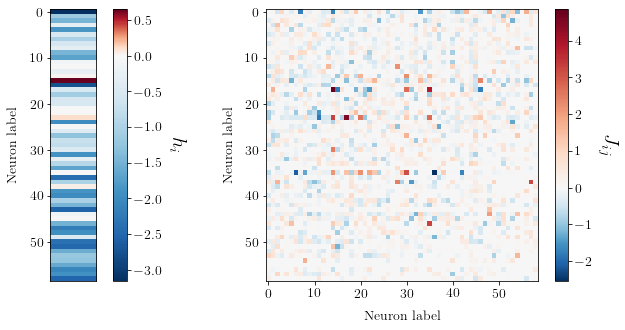

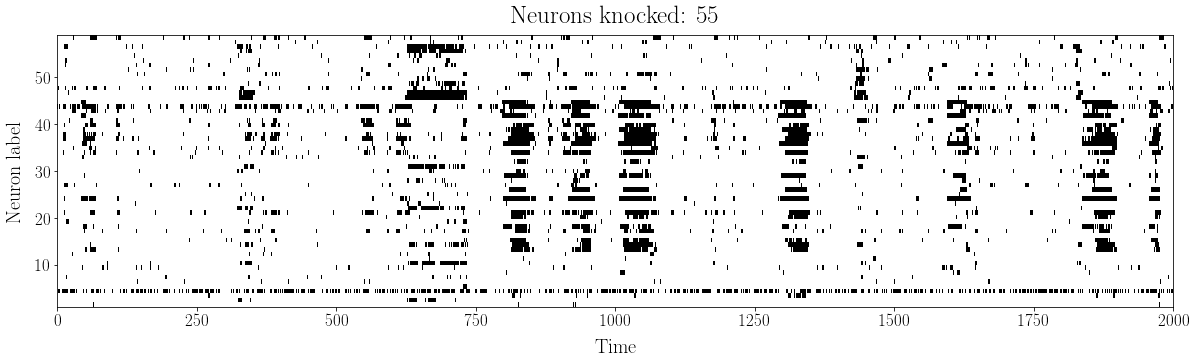

<Figure size 720x360 with 0 Axes>

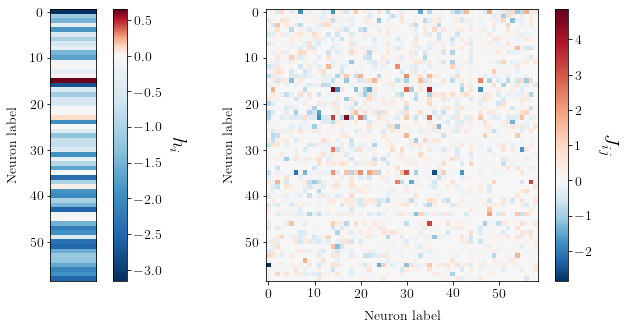

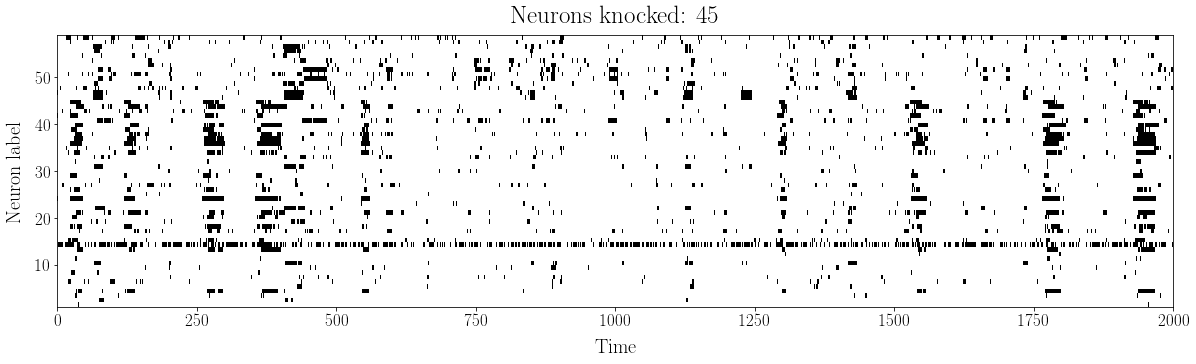

<Figure size 720x360 with 0 Axes>

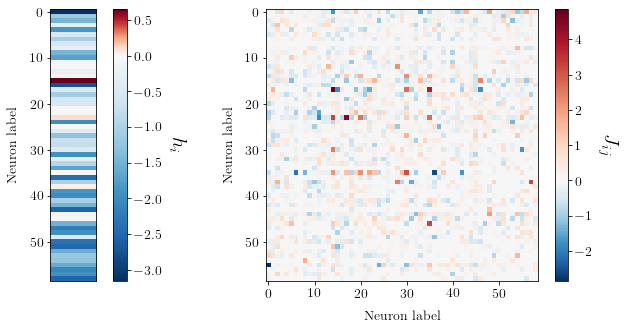

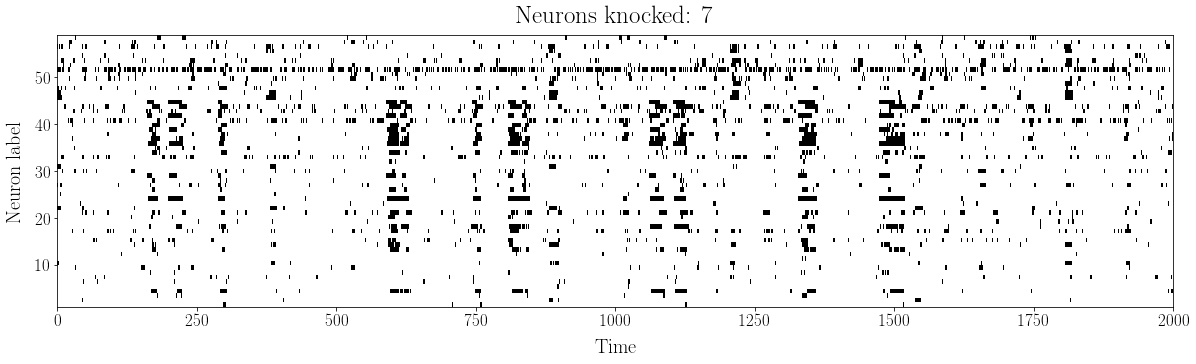

<Figure size 720x360 with 0 Axes>

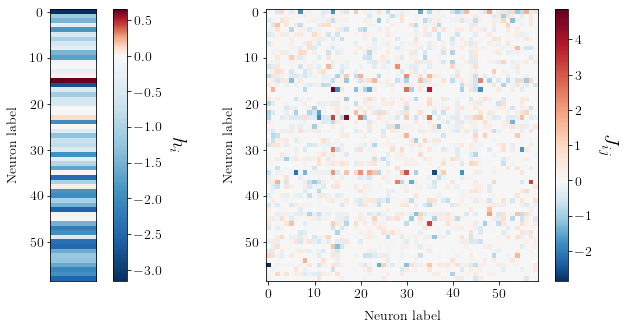

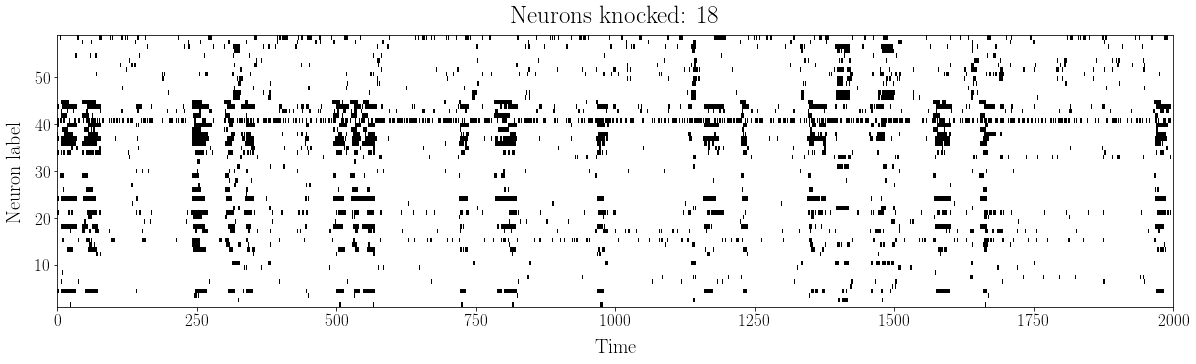

<Figure size 720x360 with 0 Axes>

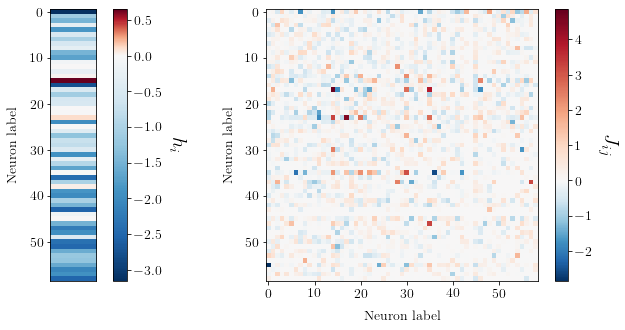

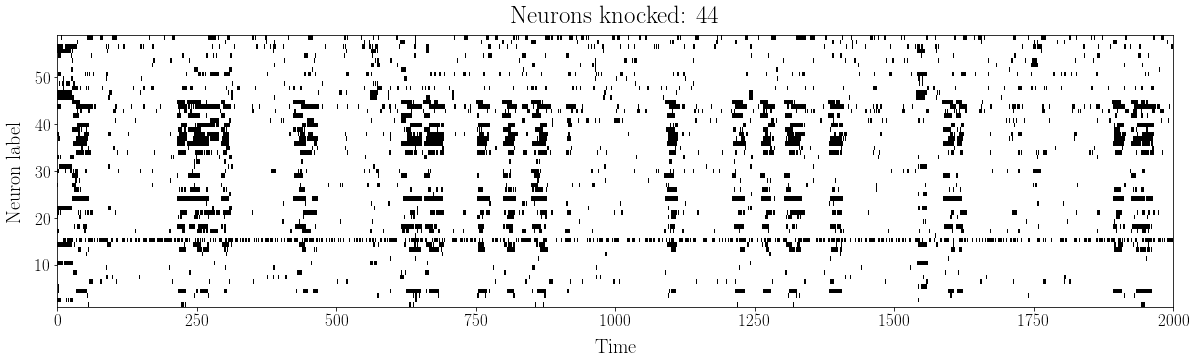

<Figure size 720x360 with 0 Axes>

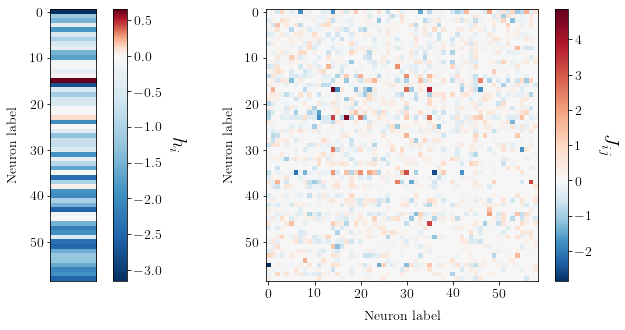

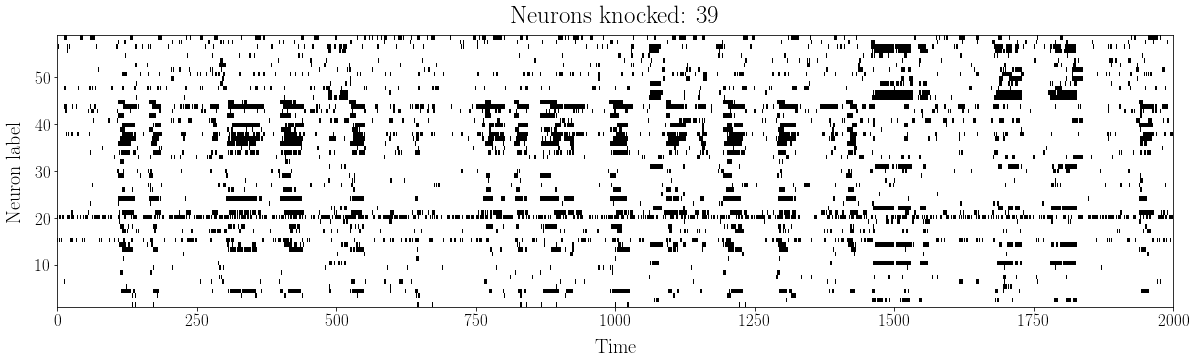

<Figure size 720x360 with 0 Axes>

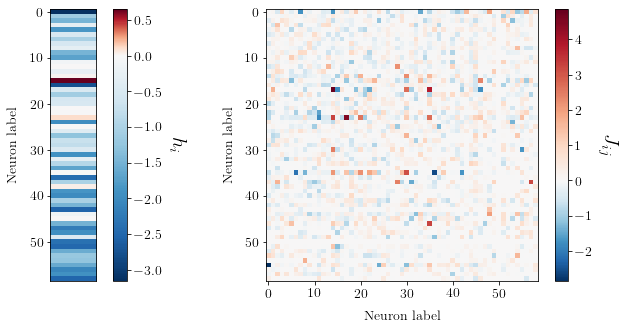

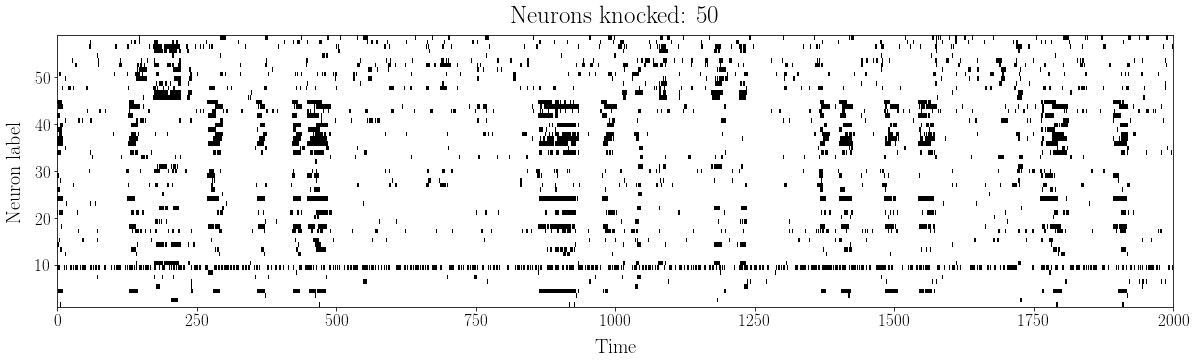

<Figure size 720x360 with 0 Axes>

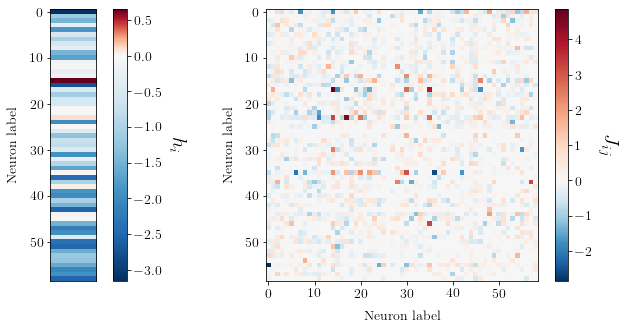

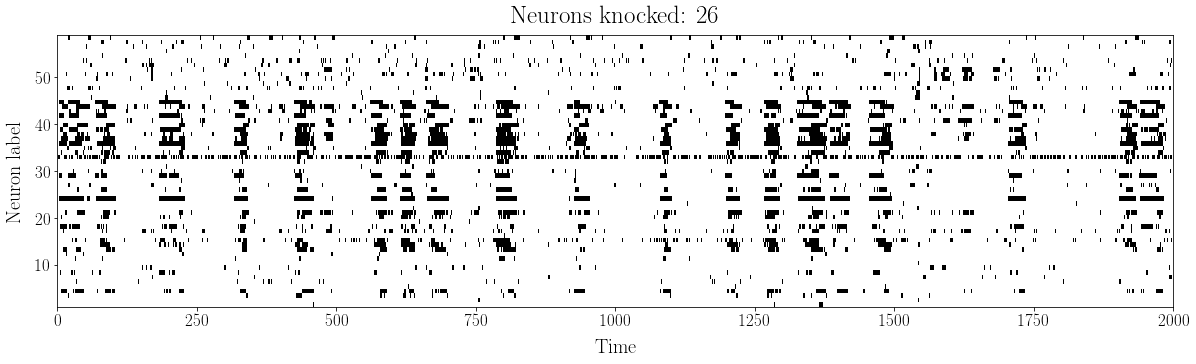

<Figure size 720x360 with 0 Axes>

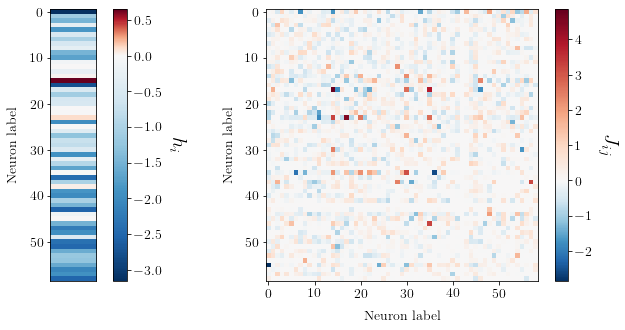

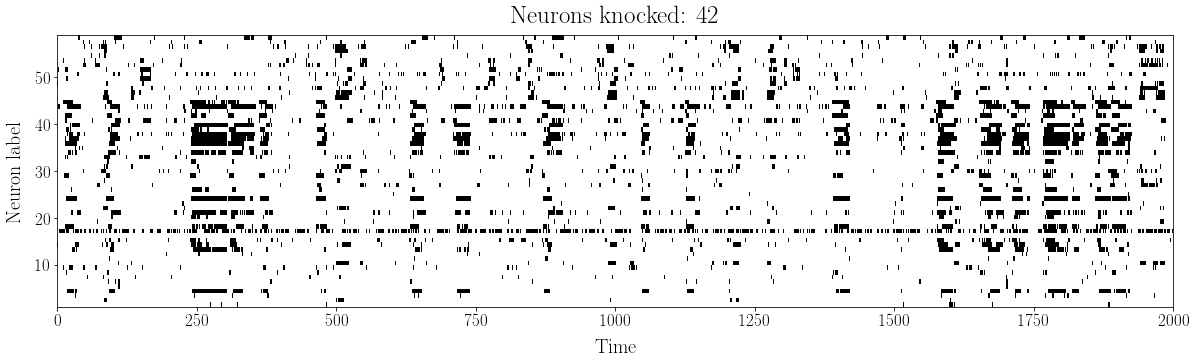

<Figure size 720x360 with 0 Axes>

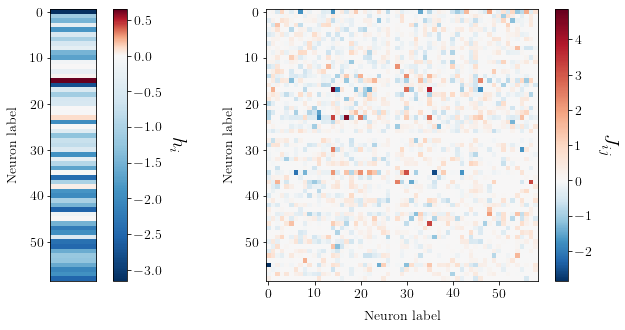

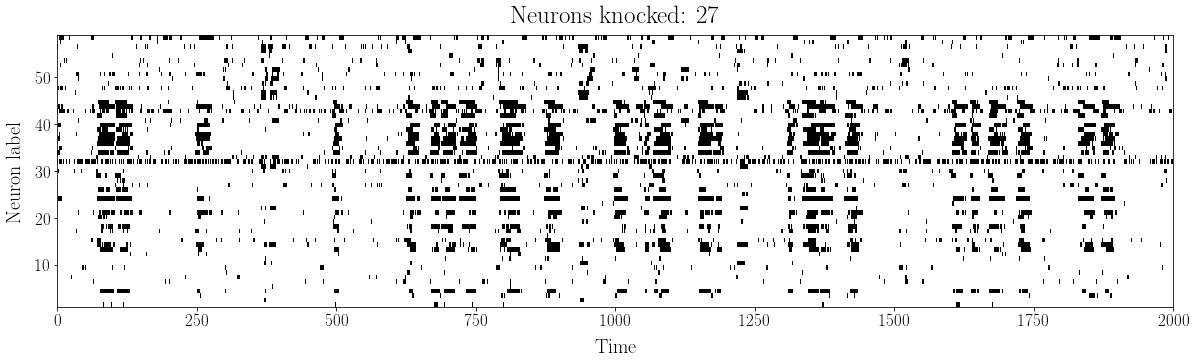

<Figure size 720x360 with 0 Axes>

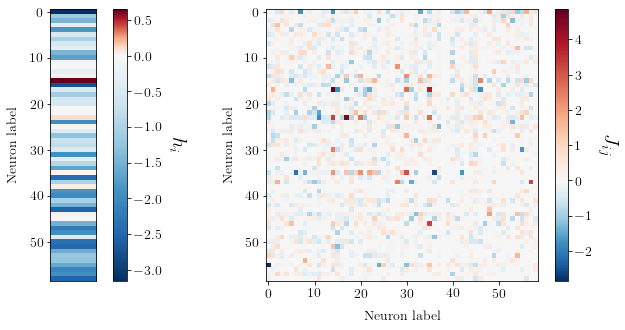

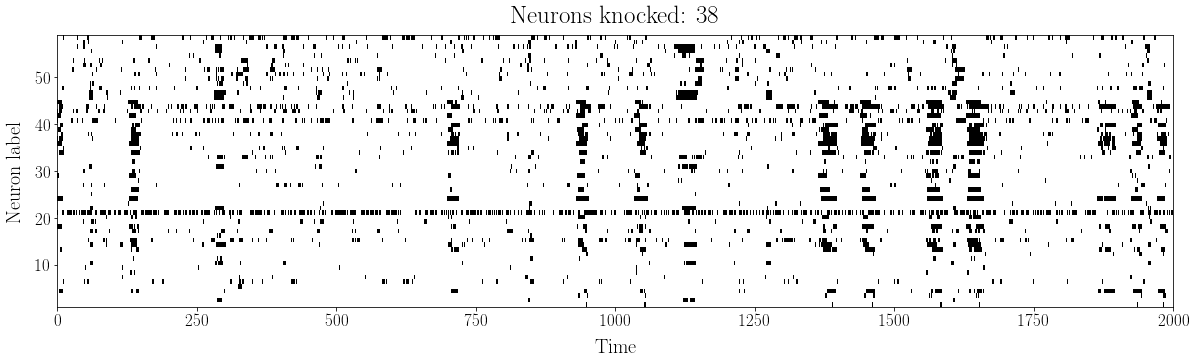

<Figure size 720x360 with 0 Axes>

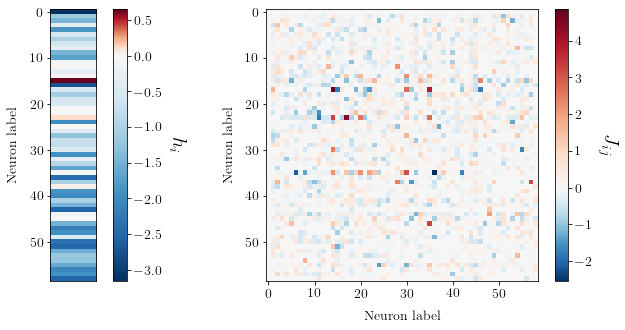

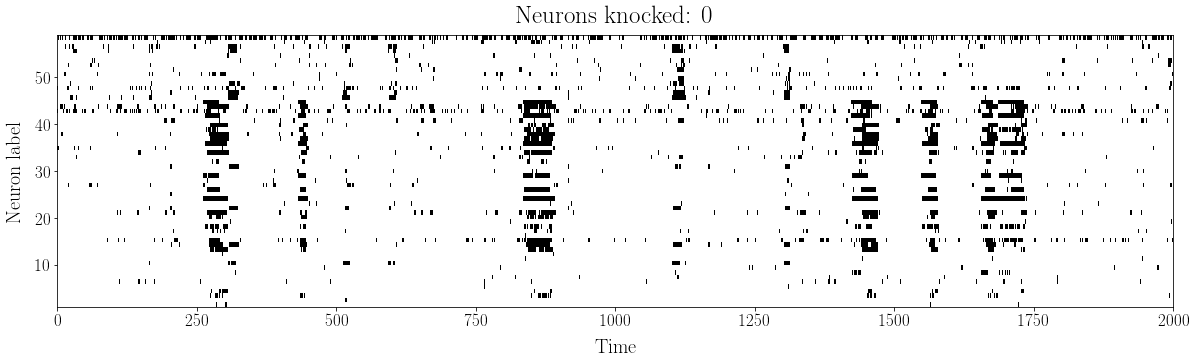

<Figure size 720x360 with 0 Axes>

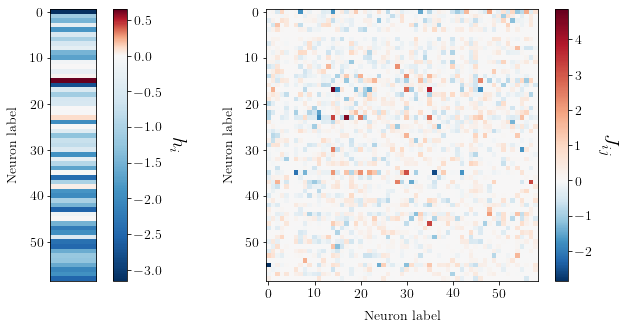

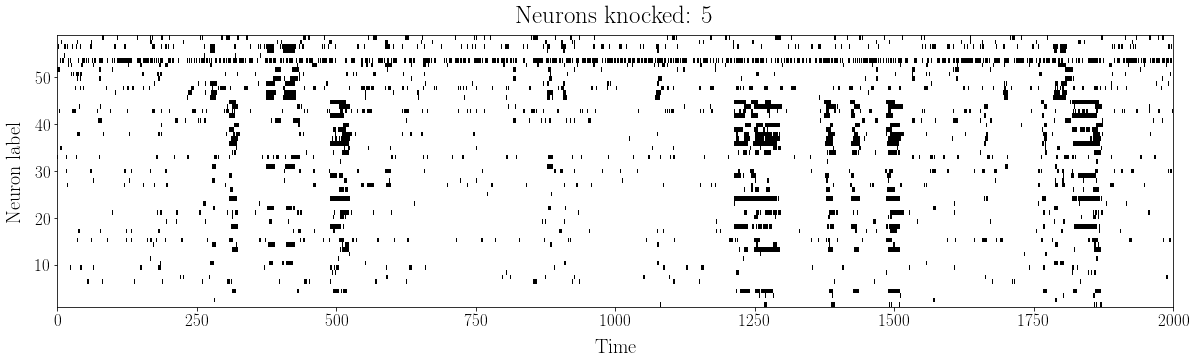

<Figure size 720x360 with 0 Axes>

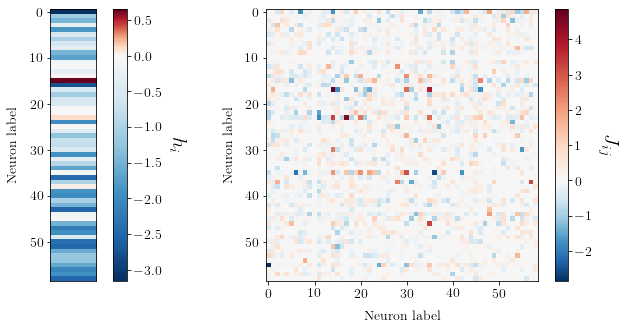

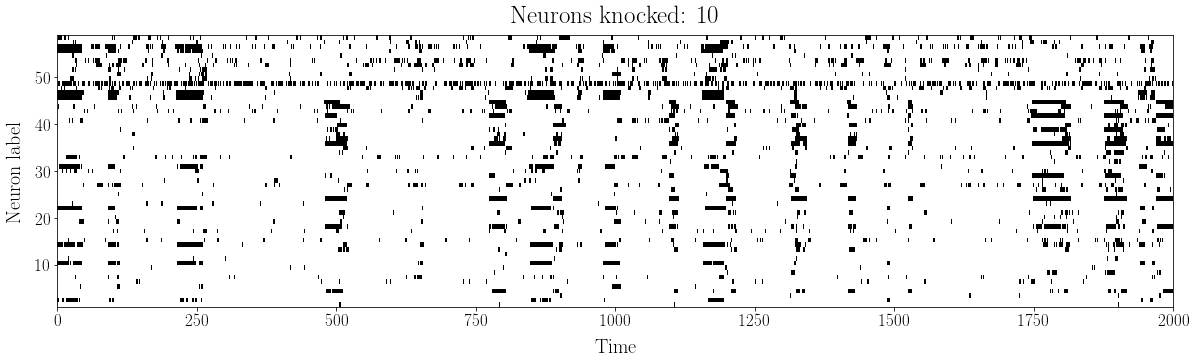

<Figure size 720x360 with 0 Axes>

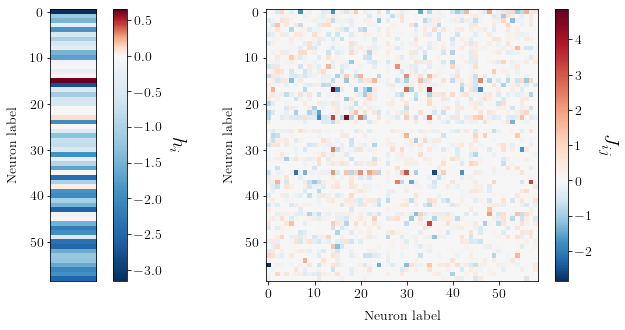

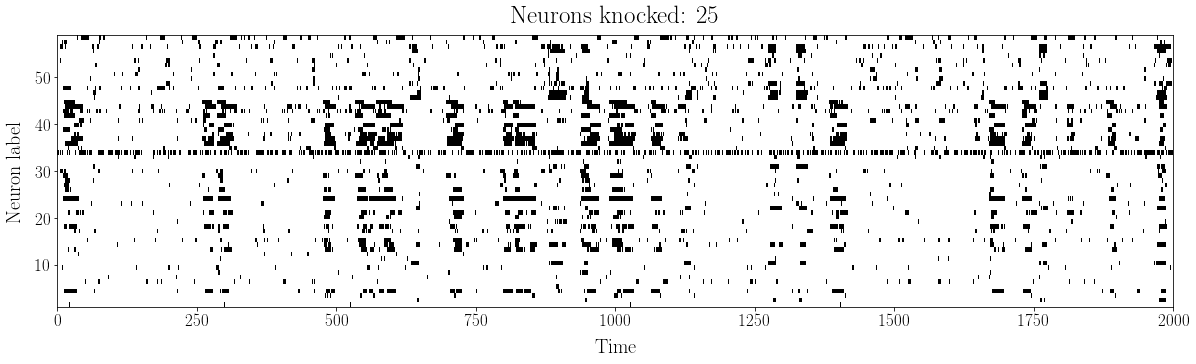

<Figure size 720x360 with 0 Axes>

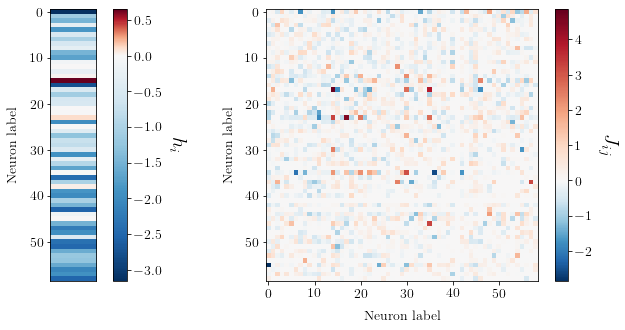

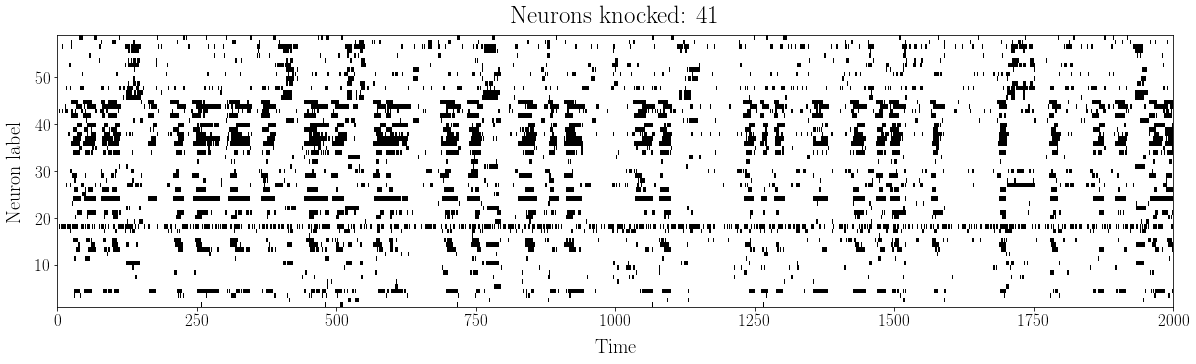

<Figure size 720x360 with 0 Axes>

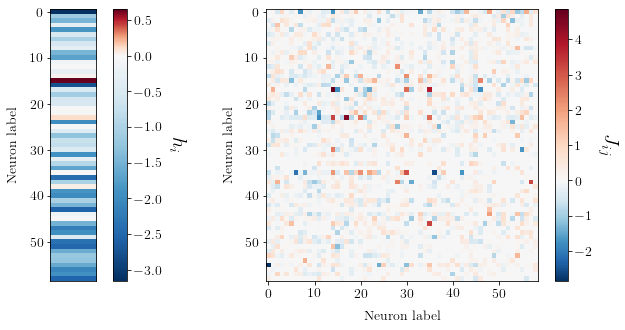

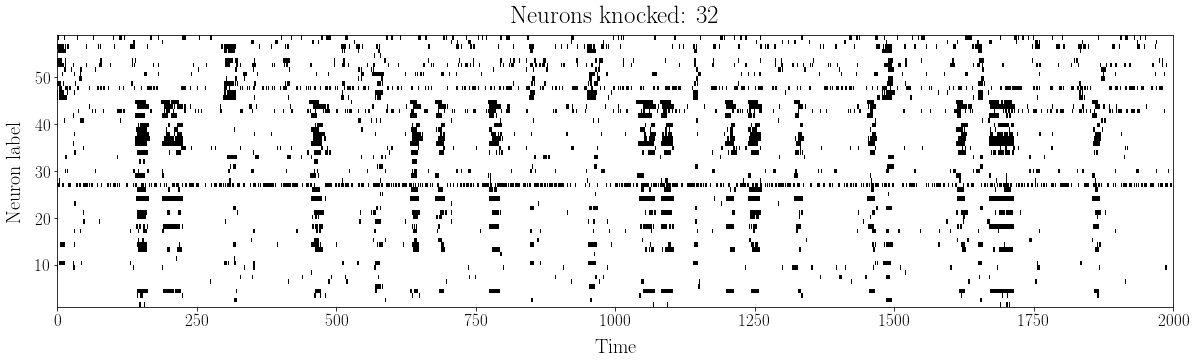

<Figure size 720x360 with 0 Axes>

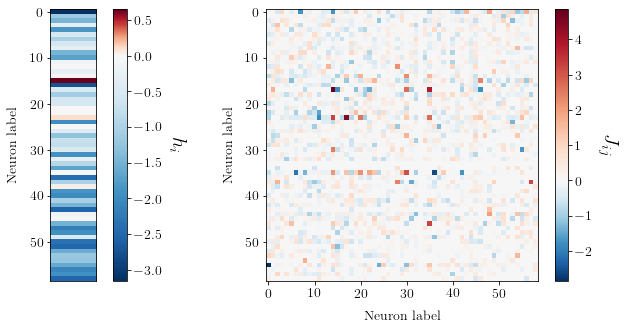

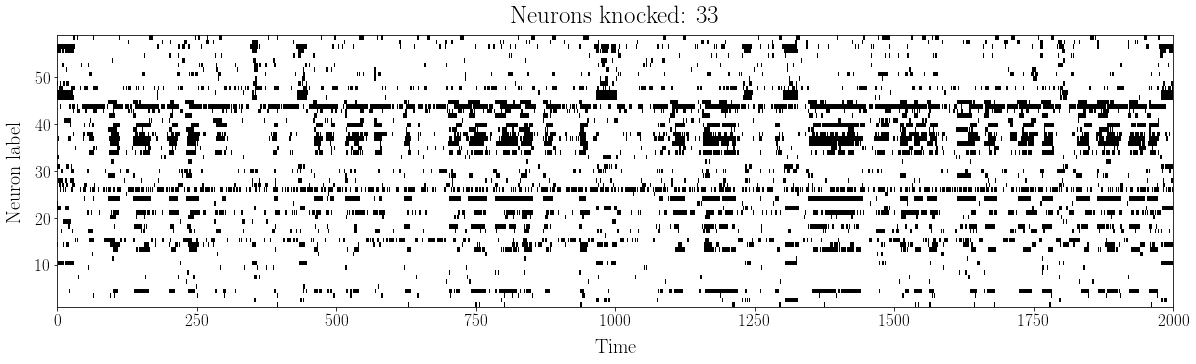

<Figure size 720x360 with 0 Axes>

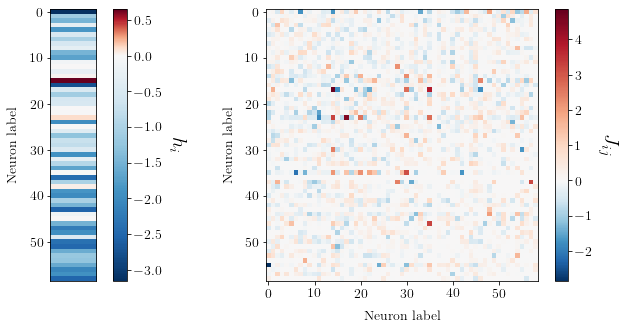

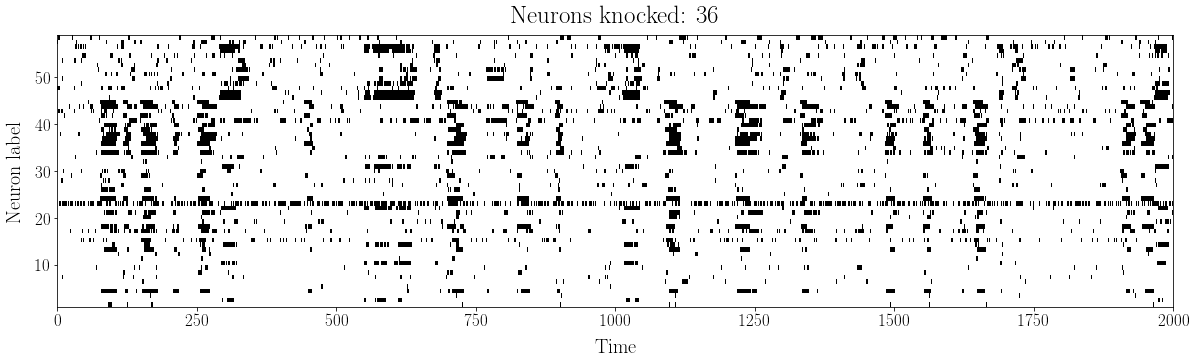

<Figure size 720x360 with 0 Axes>

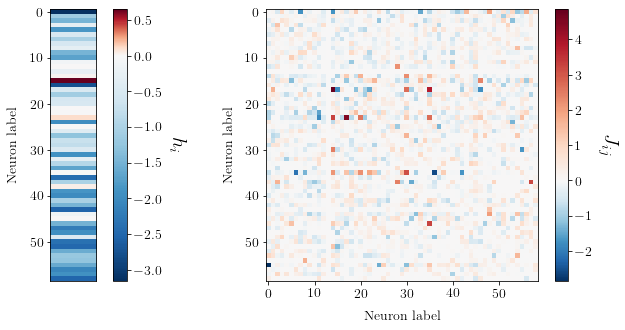

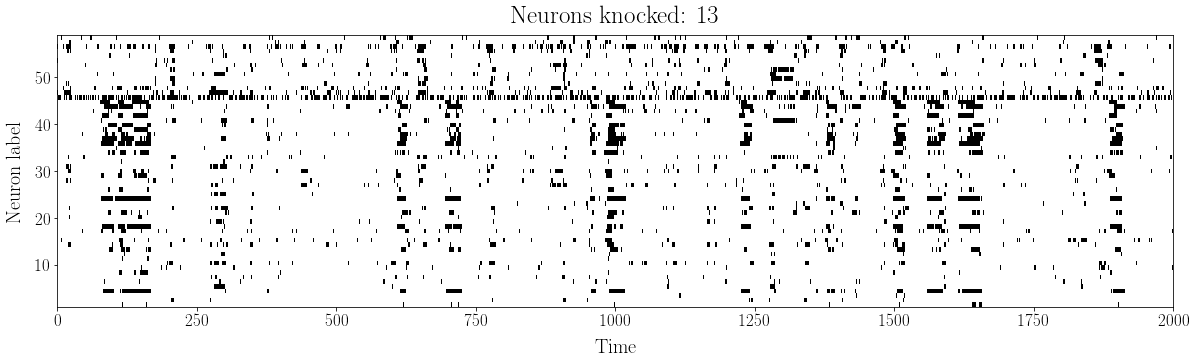

<Figure size 720x360 with 0 Axes>

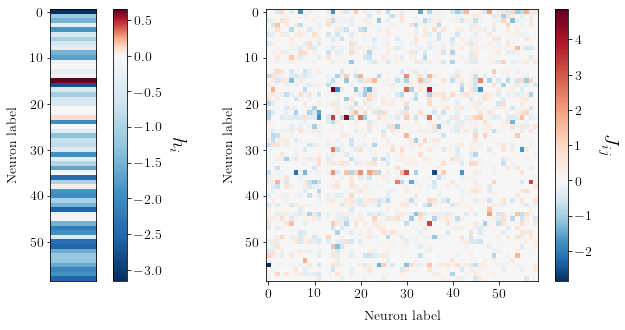

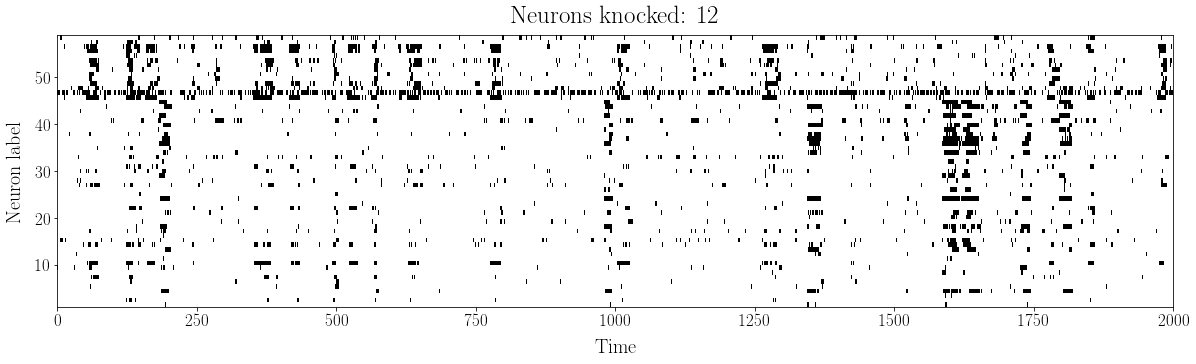

<Figure size 720x360 with 0 Axes>

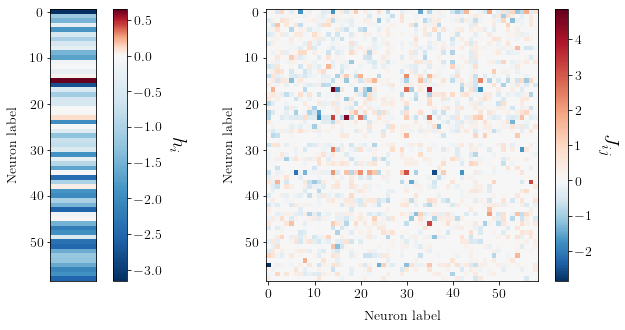

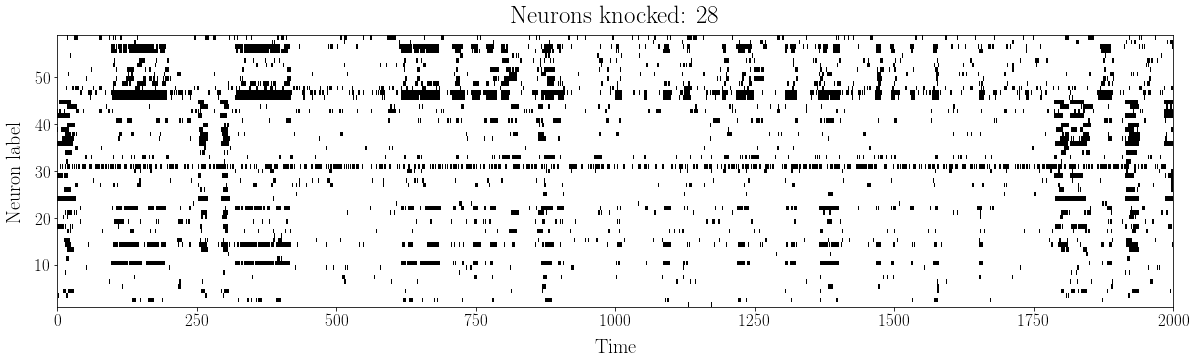

<Figure size 720x360 with 0 Axes>

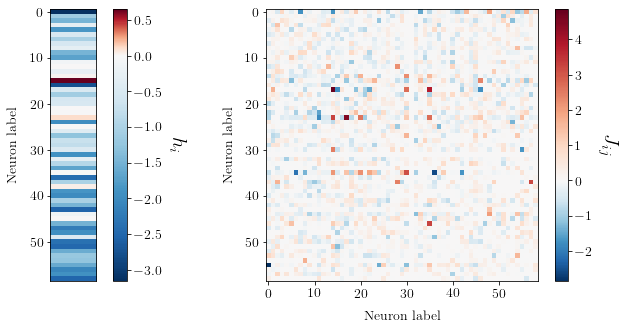

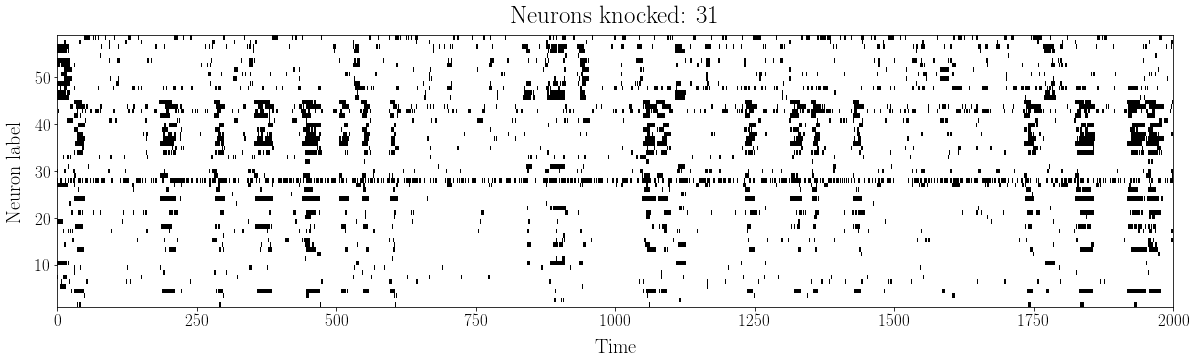

<Figure size 720x360 with 0 Axes>

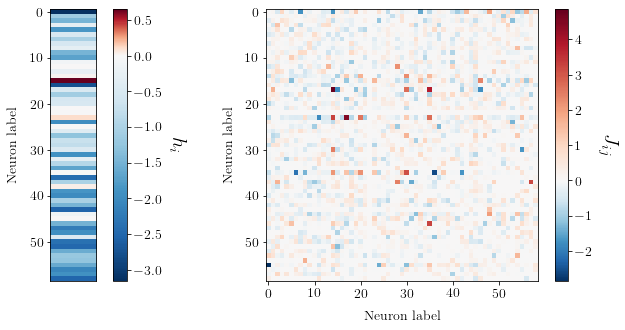

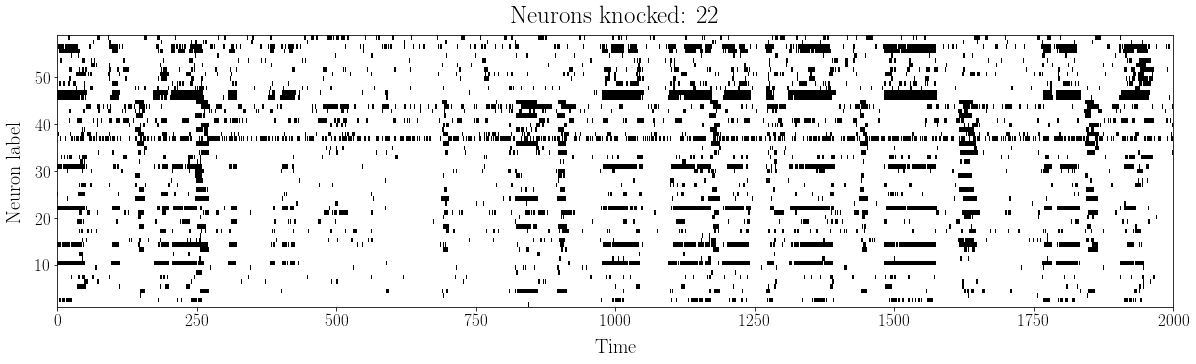

<Figure size 720x360 with 0 Axes>

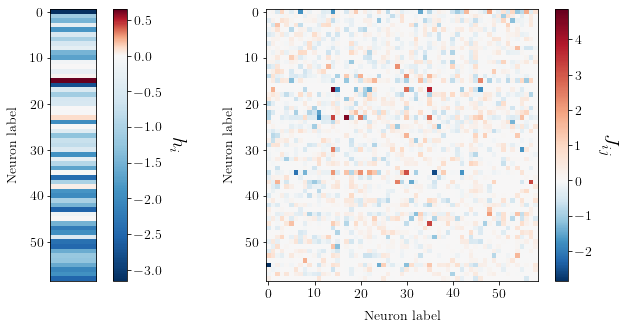

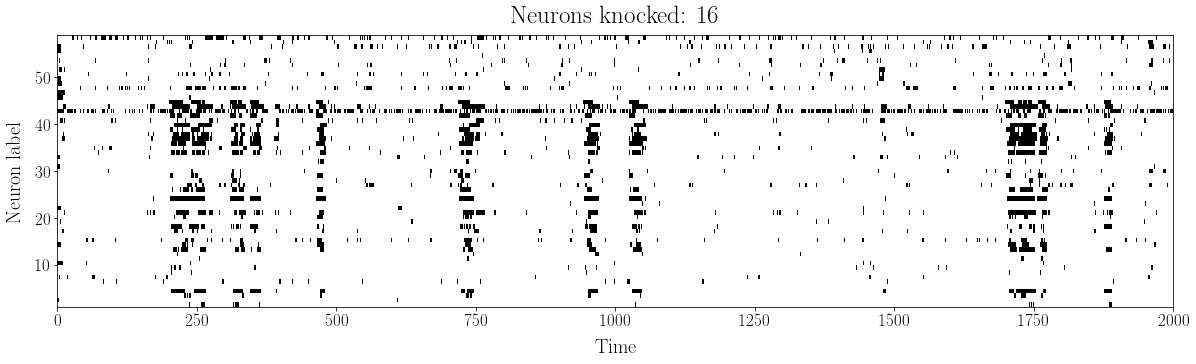

<Figure size 720x360 with 0 Axes>

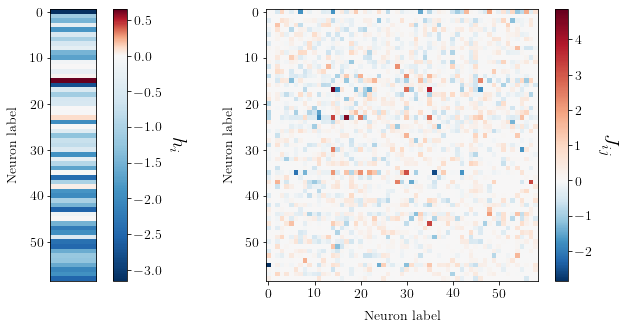

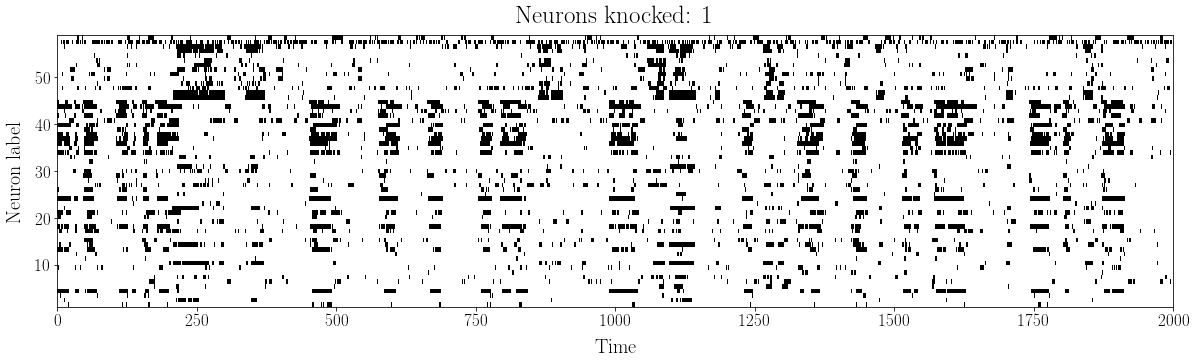

<Figure size 720x360 with 0 Axes>

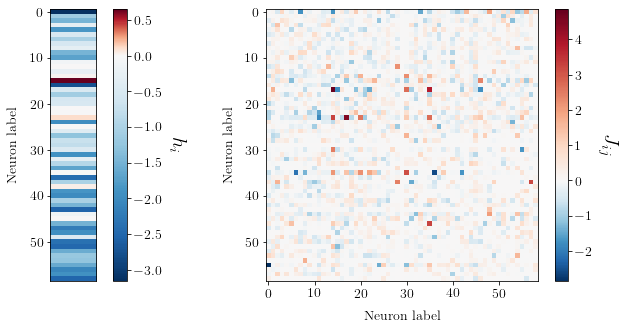

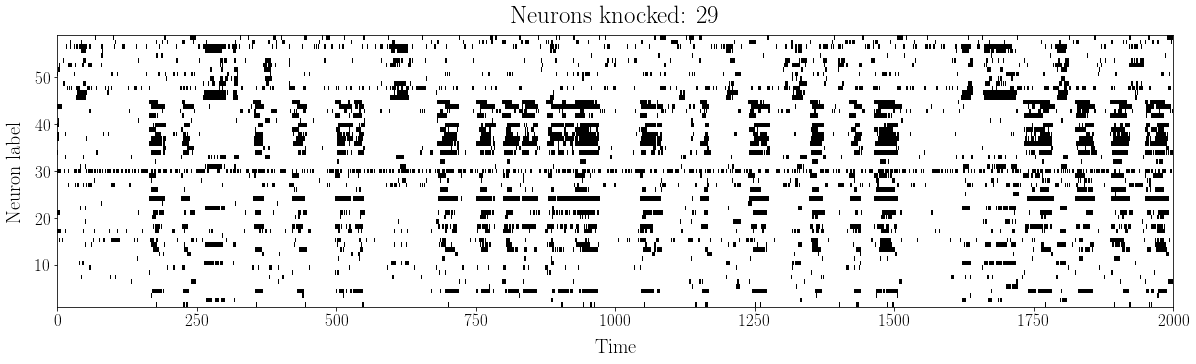

<Figure size 720x360 with 0 Axes>

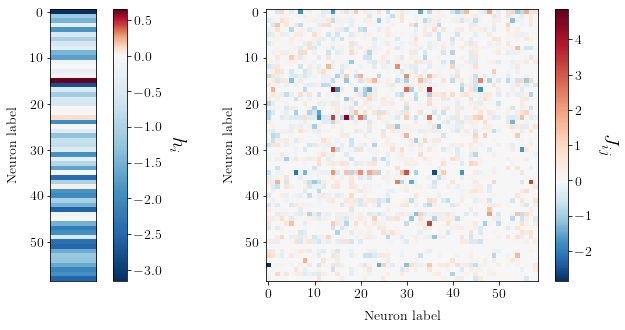

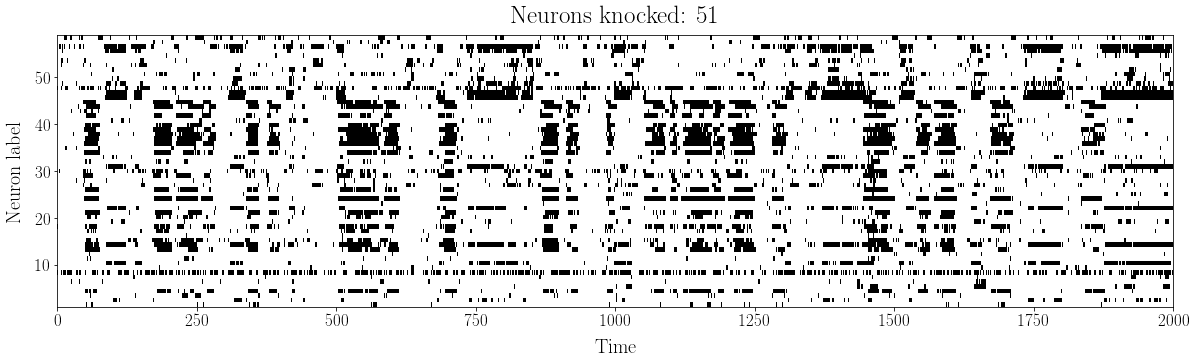

<Figure size 720x360 with 0 Axes>

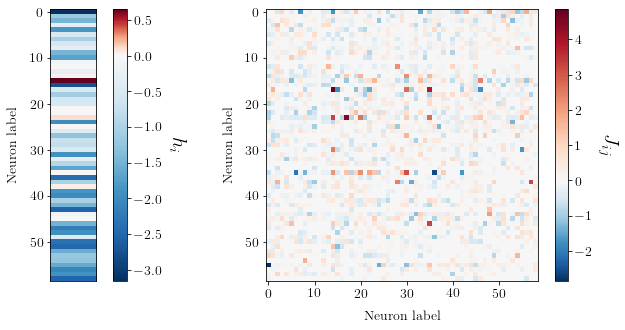

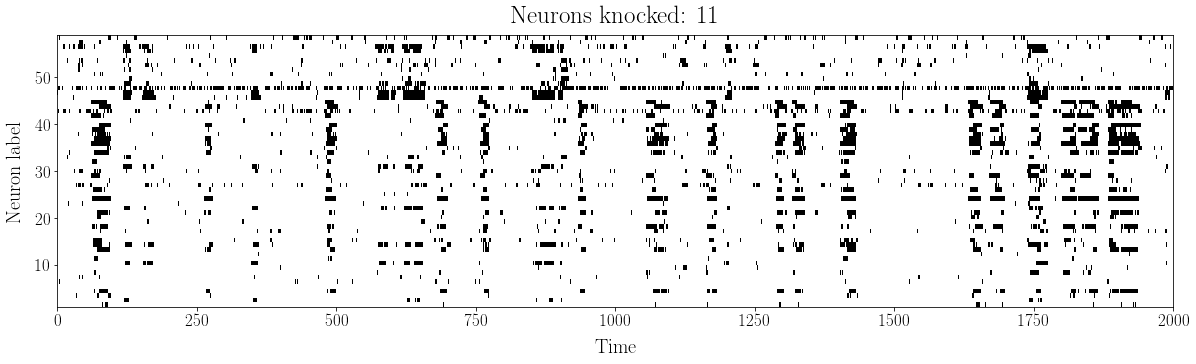

<Figure size 720x360 with 0 Axes>

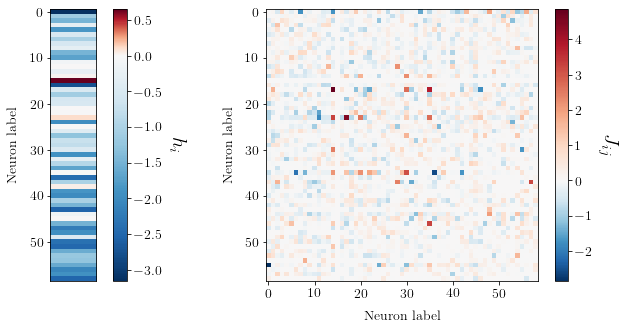

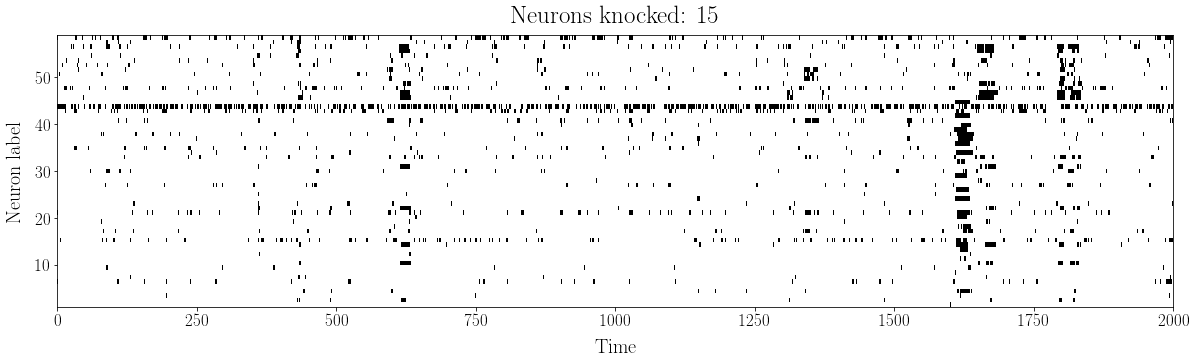

<Figure size 720x360 with 0 Axes>

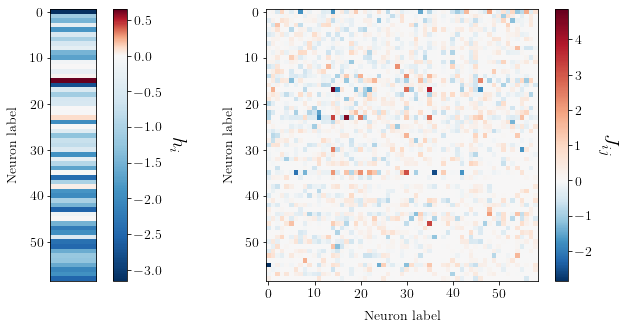

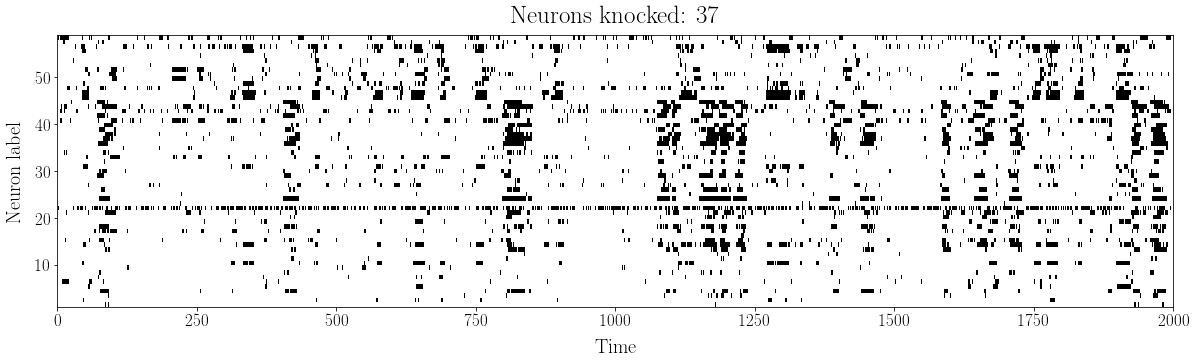

<Figure size 720x360 with 0 Axes>

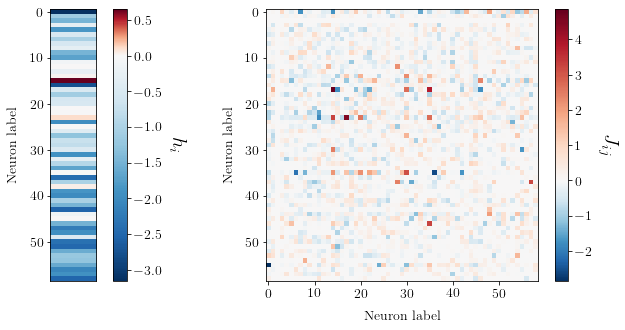

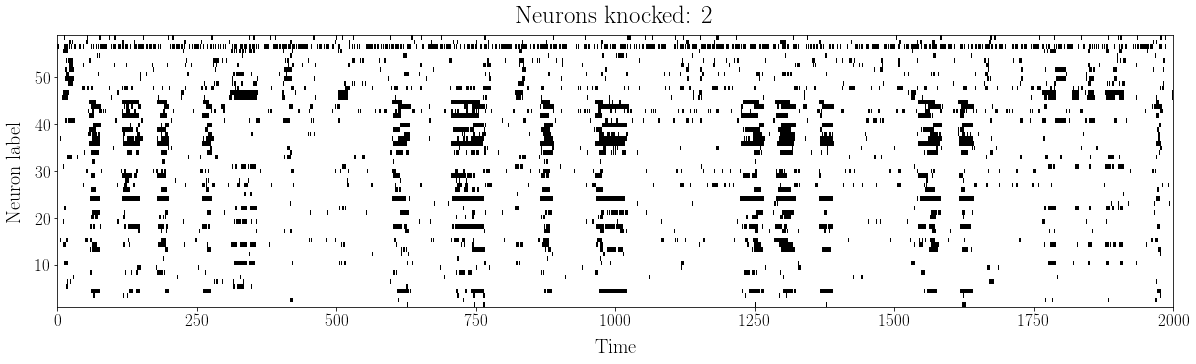

In [179]:
for idx in np.argsort(test)[::-1]:
    _, _, _ = model.knockout_neurons([idx])

In [254]:
enhanced_matrix = np.zeros((N_neurons, N_hidden*(N_hidden+N_neurons)+2))
for idx in range(N_neurons):
    enhanced_matrix[idx] = np.concatenate([abs(transition_list[idx] - transition_matrix).ravel(),
                                           abs(emission_list[idx] - emission_matrix).ravel(),
                                           DKL_tmat(transition_list[idx], transition_matrix)])

In [257]:
pca = PCA(n_components=1)
X = pca.fit_transform(enhanced_matrix)

In [263]:
np.argsort(X.ravel())

array([40, 34, 16, 25, 50,  5, 41, 53, 38, 45, 44, 11, 29, 32, 42, 31,  2,
       26, 58,  1,  7, 36, 13, 12, 27, 56, 37, 18, 47, 33, 39, 54, 28, 55,
       23, 22, 24, 48, 15,  0, 10, 51, 17, 20, 19, 43, 35, 14, 30,  8,  9,
       21,  6,  3, 49, 46, 52, 57,  4])

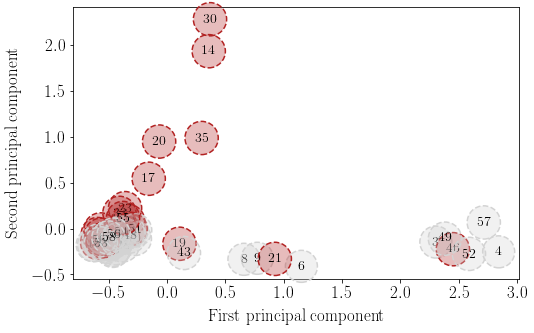

In [256]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

idx_list = np.where([emission_matrix[1] > emission_matrix[1].mean()])[1]

ax.scatter(X[:,0], X[:,1], s = 0)

for idx in range(N_neurons):
    if idx in idx_list:
        color = 'firebrick'
    else:
        color = 'lightgray'
    ax.text(X[idx,0], X[idx,1], str(idx), ha="center", va="center", fontsize = 14,
            bbox = dict(boxstyle = f"Circle, pad={0.7}",
                        fc = matplotlib.colors.colorConverter.to_rgba(color, alpha=.3),
                        ls = '--', lw = 1.5,
                        edgecolor = color))

ax.set_xlabel('First principal component', fontsize = 17, labelpad = 10)
ax.set_ylabel('Second principal component', fontsize = 17, labelpad = 10)
ax.tick_params(labelsize=17)
plt.show()

In [75]:
temporal_disruption = np.zeros((N_neurons, 2))
for idx, tmat in enumerate(transition_list):
    for i in range(2):
        temporal_disruption[idx, i] = abs(np.diff(tmat[i]))/abs(np.diff(transition_matrix[i]))

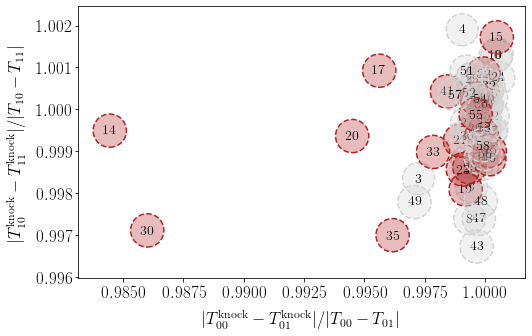

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

idx_list = np.where([emission_matrix[1] > emission_matrix[1].mean()])[1]
plt.scatter(temporal_disruption[:,0], temporal_disruption[:,1], s = 0)

for idx in range(N_neurons):
    if idx in idx_list:
        color = 'firebrick'
    else:
        color = 'lightgray'
    ax.text(temporal_disruption[idx,0], temporal_disruption[idx,1], str(idx), ha="center", va="center", fontsize = 14,
             bbox = dict(boxstyle = f"Circle, pad={0.7}",
                         fc = matplotlib.colors.colorConverter.to_rgba(color, alpha=.3),
                         ls = '--', lw = 1.5,
                         edgecolor = color))

ax.set_xlabel(r'$|T^\mathrm{knock}_{00}-T^\mathrm{knock}_{01}|/|T_{00}-T_{01}|$', fontsize = 17, labelpad = 10)
ax.set_ylabel(r'$|T^\mathrm{knock}_{10}-T^\mathrm{knock}_{11}|/|T_{10}-T_{11}|$', fontsize = 17, labelpad = 10)
ax.tick_params(labelsize=17)
ax.set_ylim(ax.get_ylim()[0]*0.9995, ax.get_ylim()[1]*1.0003)
ax.set_xlim(ax.get_xlim()[0]*0.9995, ax.get_xlim()[1]*1.0003)

plt.show()

In [96]:
emission_disruption = np.zeros((N_neurons,2))
for idx, emat in enumerate(emission_list):
    for i in range(2):
        emission_disruption[idx, i] = abs(emat[i] - emission_matrix[i]).mean()/emission_matrix[i].mean()

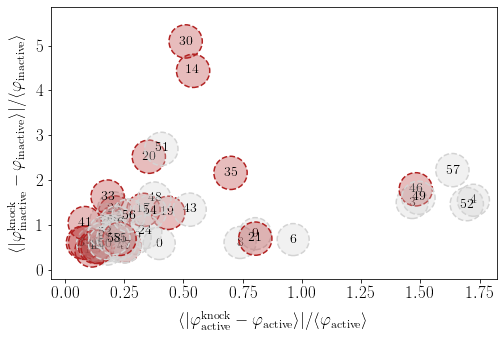

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

idx_list = np.where([emission_matrix[1] > emission_matrix[1].mean()])[1]
plt.scatter(emission_disruption[:,1], emission_disruption[:,0], s = 0)

for idx in range(N_neurons):
    if idx in idx_list:
        color = 'firebrick'
    else:
        color = 'lightgray'
    ax.text(emission_disruption[idx,1], emission_disruption[idx,0], str(idx), ha="center", va="center", fontsize = 14,
            bbox = dict(boxstyle = f"Circle, pad={0.7}",
                         fc = matplotlib.colors.colorConverter.to_rgba(color, alpha=.3),
                         ls = '--', lw = 1.5,
                         edgecolor = color))

ax.set_xlabel(r'$\langle |\varphi_\mathrm{active}^\mathrm{knock} - \varphi_\mathrm{active}\rangle|/\langle\varphi_\mathrm{active}\rangle$', fontsize = 17, labelpad = 10)
ax.set_ylabel(r'$\langle |\varphi_\mathrm{inactive}^\mathrm{knock} - \varphi_\mathrm{inactive}\rangle|/\langle\varphi_\mathrm{inactive}\rangle$', fontsize = 17, labelpad = 10)
ax.tick_params(labelsize=17)
ax.set_ylim(ax.get_ylim()[0]*(-1), ax.get_ylim()[1]*1.1)
ax.set_xlim(ax.get_xlim()[0]*(10), ax.get_xlim()[1]*1.01)

plt.show()